Projet de Machine Learning : expliquer le prix de l'électricité

Romain Foucher
Matthieu Evuort
Julie Chen


Introduction :

Le machine learning est une technologie qui vise à apprendre aux machines à tirer des enseignements des données et à s'améliorer avec l'expérience, au lieu d'être explicitement programmées pour le faire.

Ce projet consiste a expliquer le prix de l'électricité en France et en Allemagne selon une multitude de facteurs. On peut citer le climat, le réchauffement climatique, les  événements géopolitiques... De plus, chaque pays s’appuie sur un mix  énergétique qui lui est propre (nucléaire, solaire, hydrolique, gaz, charbon, etc).

 Pour cela, nous allons utiliser plusieurs méthodes afin de préparer nos données, de les analyser et de les modéliser grâce aux cours et aux TP que nous avons pu effectuer en cours mais ainsi qu'à la documantation d'internet.

Sommaire :

A) Préparation des données
B) Analyse exploratoire des données
C) Modélisation des données
D) Evaluation des modèles


A) Préparation des données

Afin de préparer nos données nous allons remplir les cases vides par la moyenne de la colonne. En effet, si nous supprimons les lignes ou les colonnes, nous perdrons des informations et nous réduisons la taille de l'échantillon. Cependant, nous n'allons pas supprimer ou remplacer les données "0.0" car elles sont utiles. En effet, il est possible que la variation du prix du charbon ou du gaz d'un pays ne change pas d'une journée à l'autre.

In [25]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
data_x = pd.read_csv('Data_X.csv')
data_y = pd.read_csv('Data_Y.csv')
data_new_x = pd.read_csv('DataNew_X.csv')

# remplacement des valeurs null par la moyenne de la colonne
for col in data_x.columns[data_x.isnull().any()]:
    data_x[col].fillna(data_x[col].mean(), inplace=True)
print(data_x)

        ID  DAY_ID COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE   
0     1054     206      FR        0.210099       -0.427458       -0.606523  \
1     2049     501      FR       -0.022399       -1.003452       -0.022063   
2     1924     687      FR        1.395035        1.978665        1.021305   
3      297     720      DE       -0.983324       -0.849198       -0.839586   
4     1101     818      FR        0.143807       -0.617038       -0.924990   
...    ...     ...     ...             ...             ...             ...   
1489   459     809      DE        1.529204        1.106682       -1.855327   
1490  1674     887      FR        1.618582        1.752840        0.611392   
1491   748    1083      DE        0.856399        0.489199       -0.255778   
1492  1454    1133      FR        0.560689       -0.343777       -0.830239   
1493   359    1118      DE        0.226730       -0.711005        0.873016   

      FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPO

Ensuite, nous fusionnons data_x et data_y pour comparer nos valeurs d'entrées avec nos valeurs de sorties en joignant sur l'ID. Puis, nous trions sur DAY_ID et COUNTRY pour une meilleure lisibilité.

In [26]:
# fusion de data_x et data_y
merged_X_Y = pd.merge(data_x, data_y, on='ID', how='inner')

# triage des données
merged_X_Y = merged_X_Y.sort_values(by=['DAY_ID', 'COUNTRY'])
print(merged_X_Y)

        ID  DAY_ID COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE   
742   1057       0      FR        0.048418       -0.465067       -0.079296  \
1211  1179       1      FR        0.966997        1.222131        0.331356   
1468   111       2      DE       -0.068972       -0.667390       -1.102015   
1408  1327       2      FR       -0.068972       -0.667390       -1.102015   
680    800       3      DE       -0.134670       -0.834564       -1.051716   
...    ...     ...     ...             ...             ...             ...   
986    771    1212      DE       -0.046100       -0.520506       -0.270515   
1007  1987    1212      FR       -0.046100       -0.520506       -0.270515   
1465   472    1213      DE        1.407027        1.313254       -0.456126   
873   1688    1213      FR        1.407027        1.313254       -0.456126   
1437  1049    1215      FR        0.544810       -0.378158       -0.065993   

      FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPO

Puisque nous étudions la France et l'Allemagne nous créons deux datas : data_FR et data_DE et nous ajoutons leurs colonnes respectives sans oublier de mettre TARGET.

In [27]:
# création de deux datas pour la France et l'Allemagne
data_FR = merged_X_Y.loc[merged_X_Y['COUNTRY'] == 'FR']
data_DE = merged_X_Y.loc[merged_X_Y['COUNTRY'] == 'DE']

# triage des deux datas avec leurs valeurs correspondantes
data_FR = data_FR.filter(regex='FR|GAS_RET|COAL_RET|TARGET', axis=1)
print(data_FR)

data_DE = data_DE.filter(regex='DE|GAS_RET|COAL_RET|TARGET', axis=1)
print(data_DE)


      FR_CONSUMPTION  DE_FR_EXCHANGE  FR_DE_EXCHANGE  FR_NET_EXPORT   
742        -0.465067       -0.079296        0.079296       0.650577  \
1211        1.222131        0.331356       -0.331356       0.778627   
1408       -0.667390       -1.102015        1.102015       0.256736   
329        -0.834564       -1.051716        1.051716      -0.612133   
512        -0.470371        0.144615       -0.144615      -1.811403   
...              ...             ...             ...            ...   
479        -0.709011        0.427976       -0.427976      -1.678101   
1451        1.301061        1.565552       -1.565552      -0.072643   
1007       -0.520506       -0.270515        0.270515      -0.789824   
873         1.313254       -0.456126        0.456126      -0.069222   
1437       -0.378158       -0.065993        0.065993       0.257829   

      FR_NET_IMPORT    FR_GAS   FR_COAL  FR_HYDRO  FR_NUCLEAR  FR_SOLAR   
742       -0.650577 -0.261565  0.095197  0.677089   -0.357168  1.185155 

Les valeurs des différents attributs sont comparables car ce sont toutes des variations dans le temps.

B) Analyse exploratoire des données

Afin de faire un aperçu des données nous utilisons plusieurs fonctions :


In [28]:
# affiche le type de chaque colonne et si elles sont nulles ou non
data_FR.info()
data_DE.info()

# affiche la distribution, la plage de valeurs et la signification de chaque colonne
data_FR.describe()
data_DE.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 851 entries, 742 to 1437
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   FR_CONSUMPTION    851 non-null    float64
 1   DE_FR_EXCHANGE    851 non-null    float64
 2   FR_DE_EXCHANGE    851 non-null    float64
 3   FR_NET_EXPORT     851 non-null    float64
 4   FR_NET_IMPORT     851 non-null    float64
 5   FR_GAS            851 non-null    float64
 6   FR_COAL           851 non-null    float64
 7   FR_HYDRO          851 non-null    float64
 8   FR_NUCLEAR        851 non-null    float64
 9   FR_SOLAR          851 non-null    float64
 10  FR_WINDPOW        851 non-null    float64
 11  FR_RESIDUAL_LOAD  851 non-null    float64
 12  FR_RAIN           851 non-null    float64
 13  FR_WIND           851 non-null    float64
 14  FR_TEMP           851 non-null    float64
 15  GAS_RET           851 non-null    float64
 16  COAL_RET          851 non-null    float64
 17 

,DE_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,DE_NET_IMPORT,DE_GAS,DE_COAL,DE_HYDRO,DE_NUCLEAR,DE_SOLAR,DE_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,DE_RAIN,DE_WIND,DE_TEMP,GAS_RET,COAL_RET,TARGET
count,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000
mean,0.379809,-0.172616,0.172616,-0.327798,0.327798,0.814385,-0.255720,0.606018,-0.601507,0.301190,0.154515,-0.448017,0.011554,-0.038166,0.225552,0.006103,0.082186,0.051654,0.148044
std,0.682092,0.988550,0.988550,0.930585,0.930585,0.848854,0.773450,1.083933,0.882778,1.088365,1.070344,0.789194,0.844800,0.967171,1.046143,0.909617,1.105919,1.022188,1.047022
min,-2.265563,-2.856874,-2.634831,-2.464849,-2.279619,-1.004008,-1.491593,-1.373985,-2.689387,-1.442296,-1.235802,-2.879041,-2.613569,-2.128531,-1.880419,-4.549638,-5.349463,-5.392852,-3.075929
25%,-0.069473,-0.979886,-0.640639,-1.026464,-0.365121,0.166714,-0.907156,-0.227007,-1.339070,-0.689997,-0.688578,-0.904350,-0.482059,-0.621853,-0.561814,-0.568777,-0.604950,-0.455707,-0.324693
50%,0.288112,-0.172069,0.172069,-0.404441,0.404441,0.809862,-0.325659,0.402352,-0.343602,0.296254,-0.078279,-0.289221,0.071007,-0.207939,0.070153,0.009451,0.034673,0.047114,0.005057
75%,0.895751,0.640639,0.979886,0.365121,1.026464,1.445299,0.283322,1.342489,0.070503,1.224825,0.643680,0.119871,0.575759,0.268913,0.741858,0.519411,0.691052,0.634172,0.386596
max,2.033851,2.634831,2.856874,2.279619,2.464849,3.118082,1.902490,4.181936,0.842046,2.696571,3.509017,1.070902,2.254155,7.756118,5.085624,2.858758,5.674778,3.607281,7.138604


info() permet d'afficher le type de chaque colonnes et si elles sont nulles ou non
describe() permet d'afficher la somme de toutes les lignes de chaque colonne avec "count", la moyenne de la colonne avec "mean", l'écart-type de la colonne avec "std", le minimum et le maximum de chaque colonne avec "min" et "max". De plus, nous avons les 25%, les 50% et les 75% premières valeurs de chaque colonne.


Pour éxaminer la relation entre les variables caractéristiques (chaque colonne) et la variable cible (TARGET) on utilise des techniques graphiques telles que des histogrammes, pour data_DE on n'oublie pas de prendre en compte la colonne en plus dans nos paramètres :

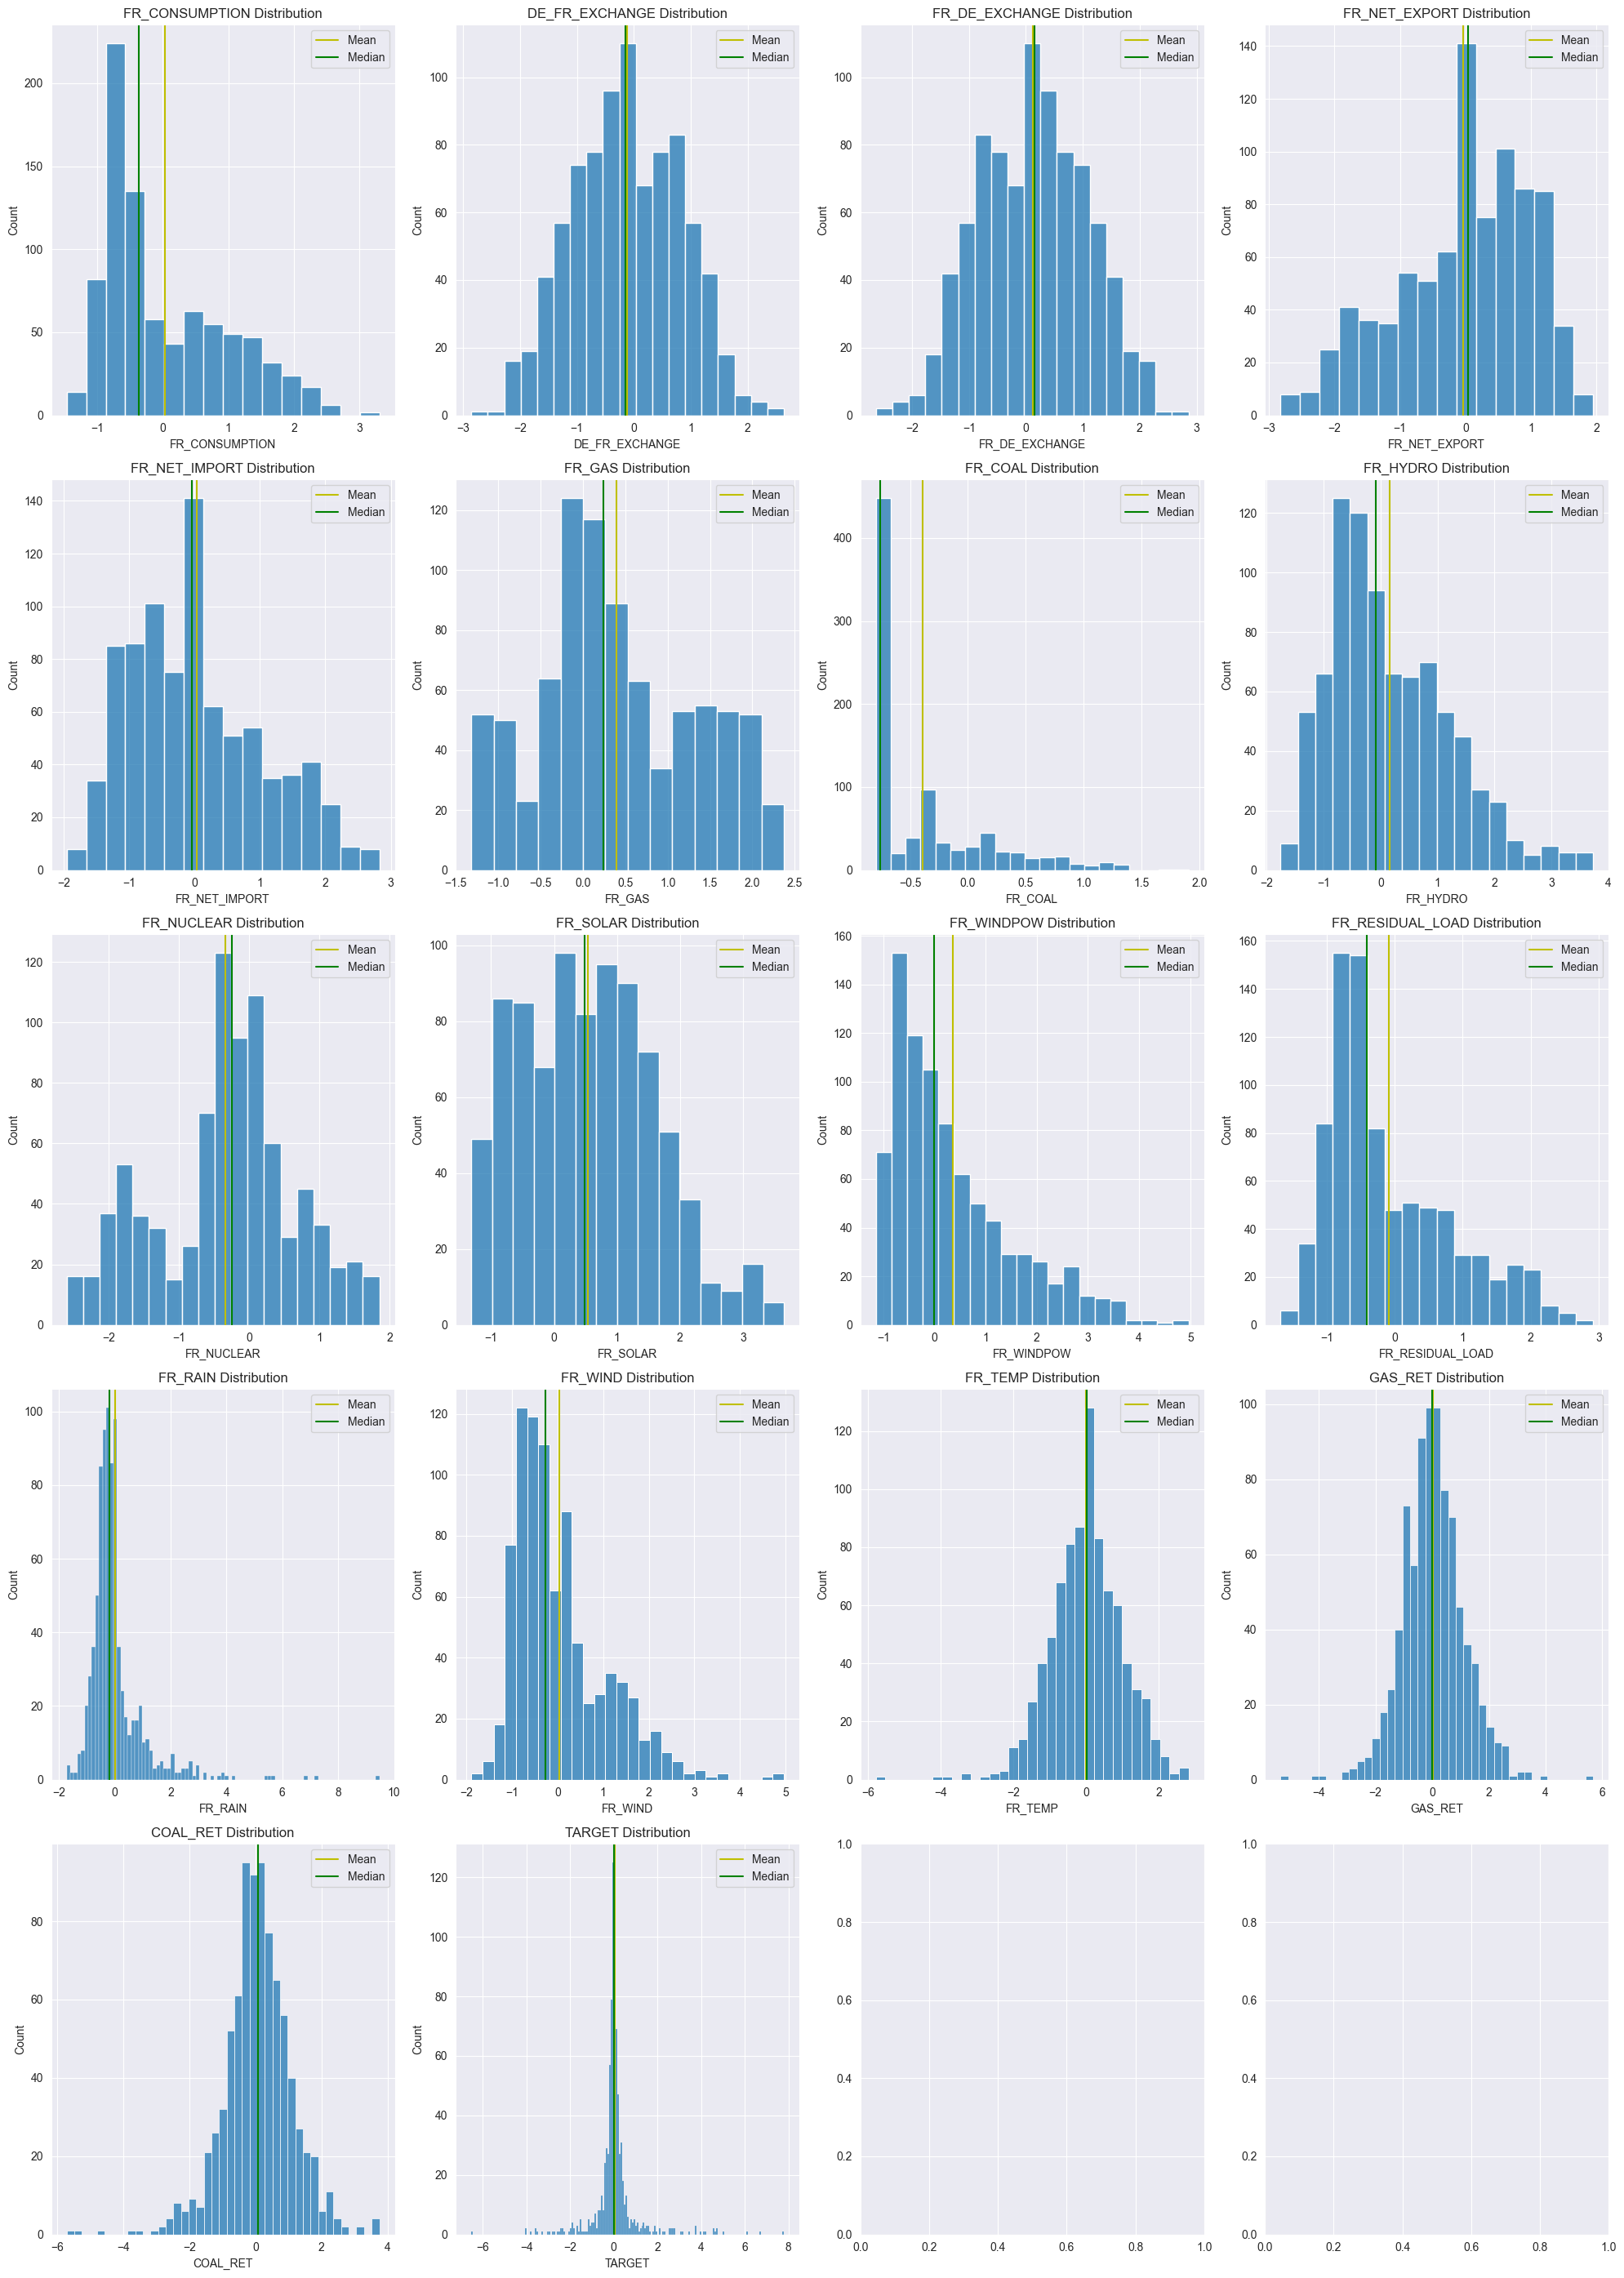

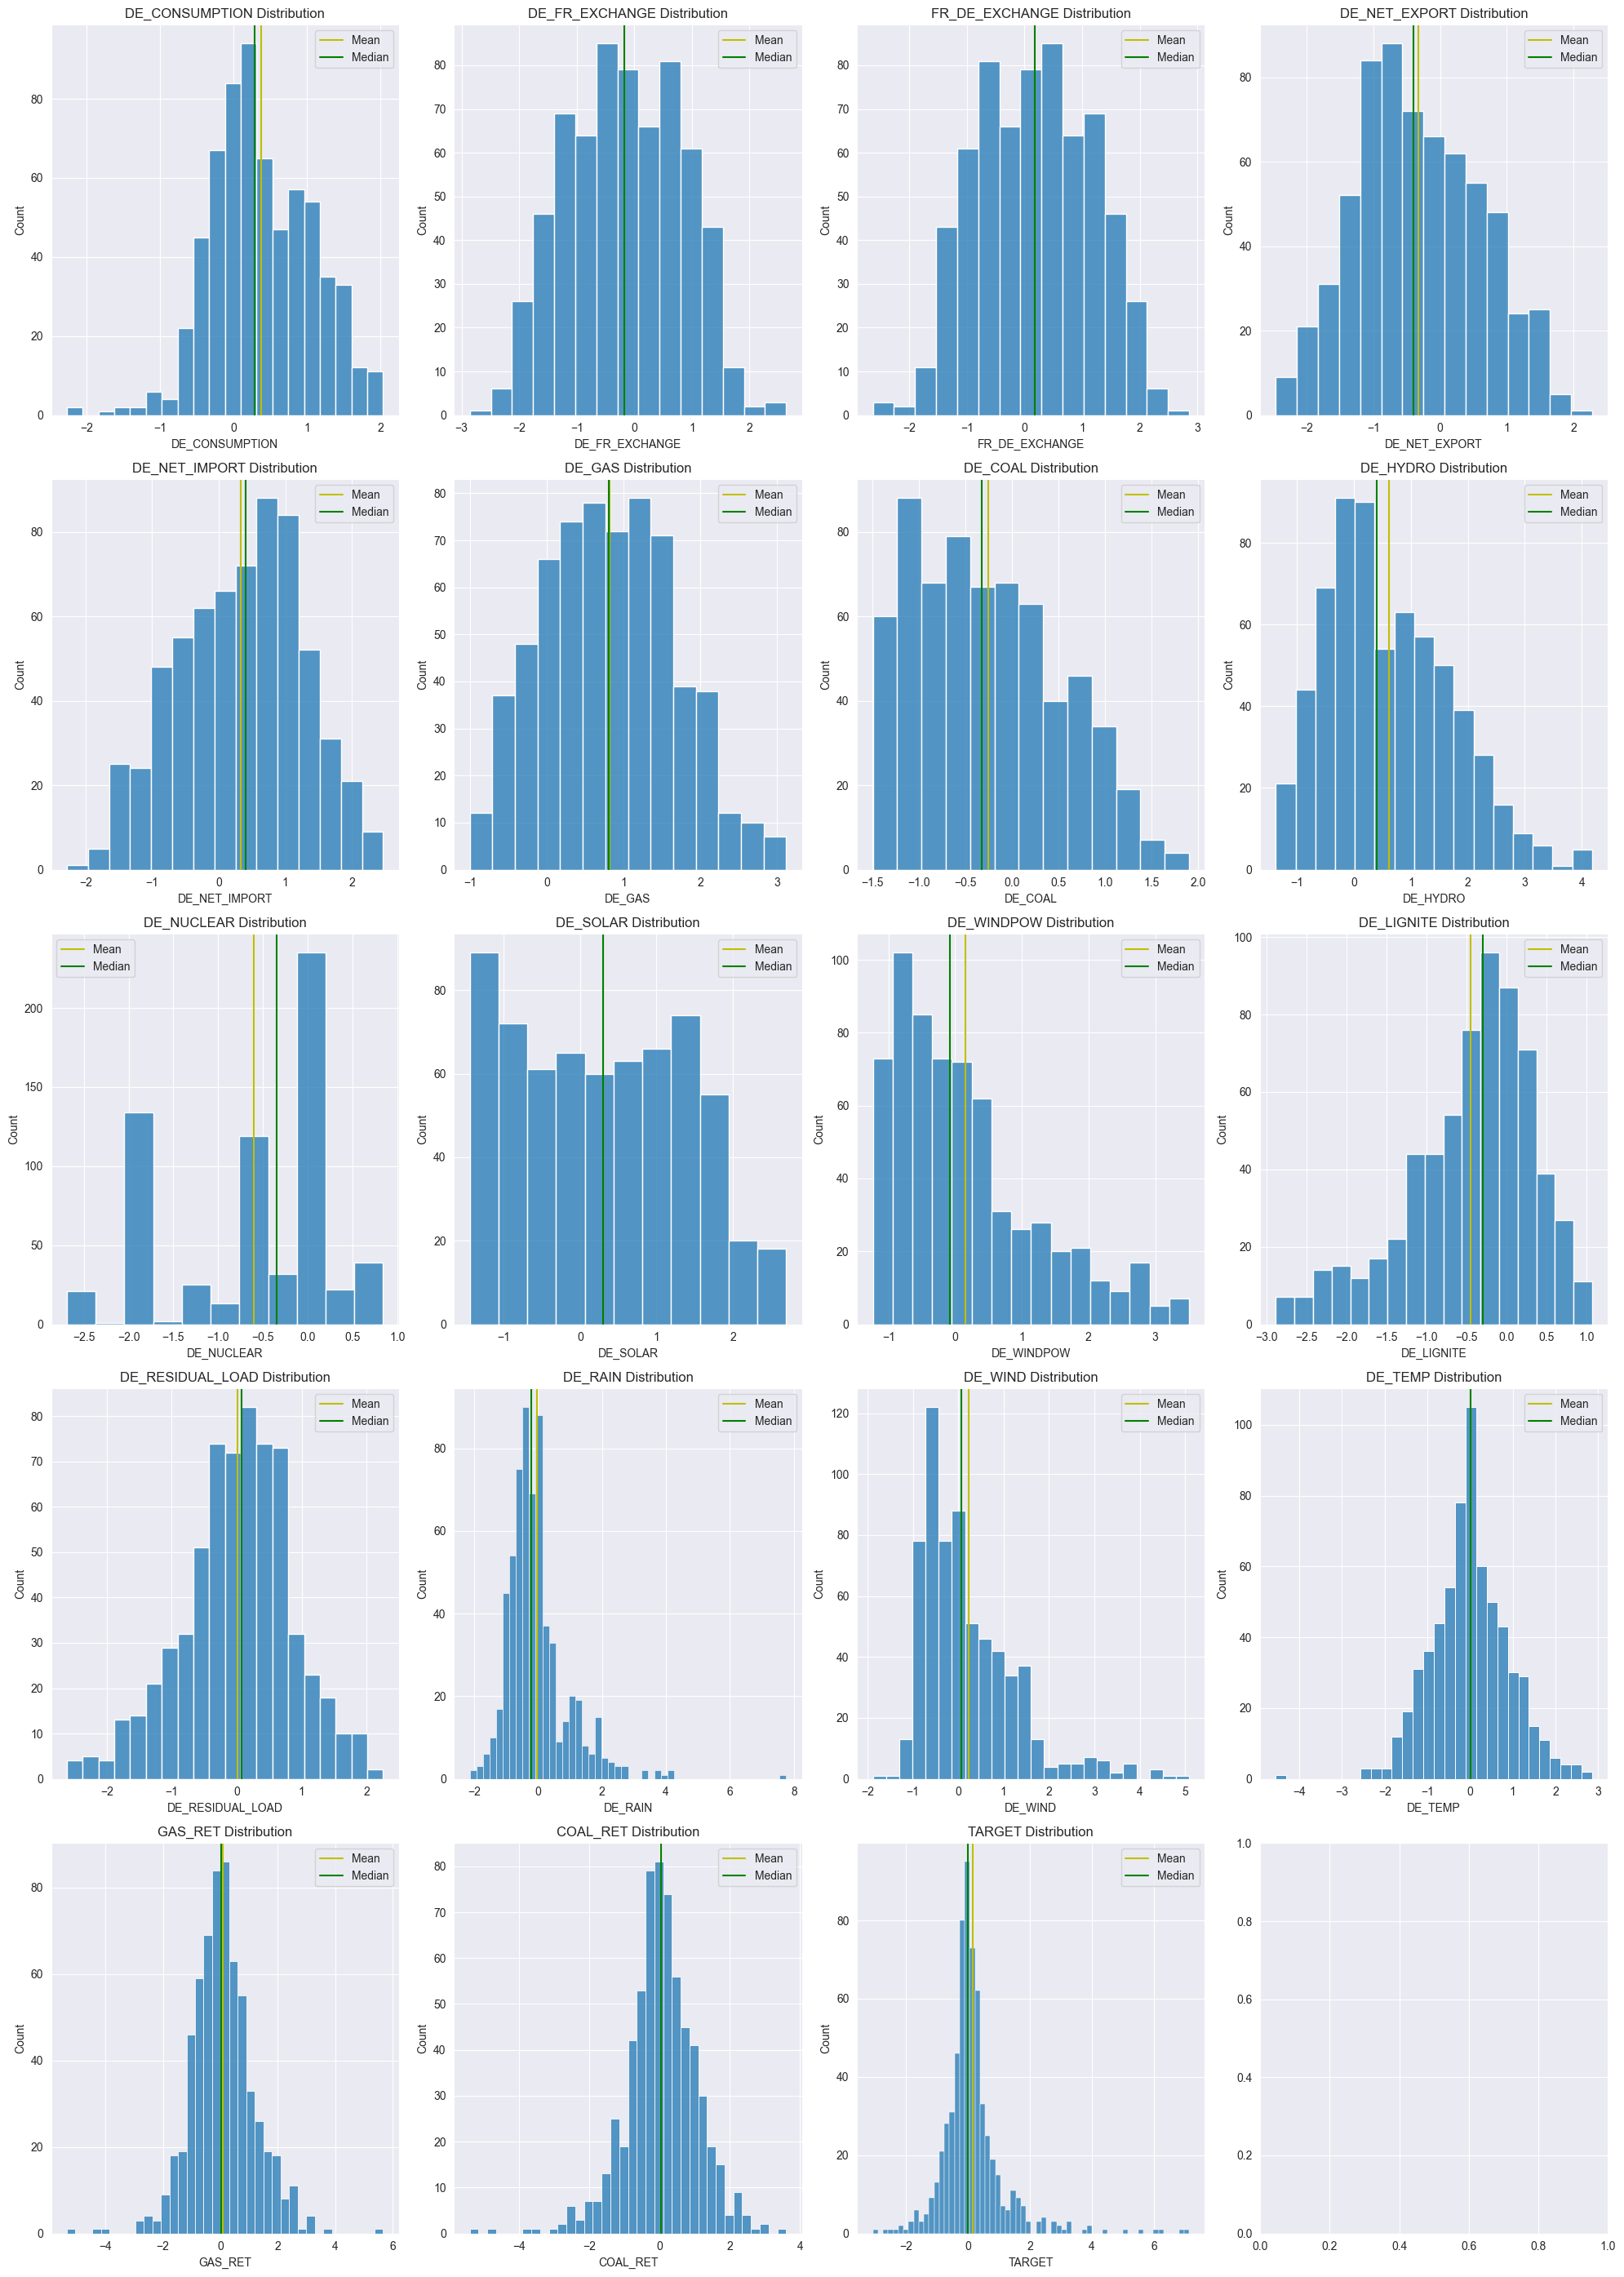

In [29]:
# création des histogrammes
# pour la France
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 28))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for i, ax in enumerate(axes.flatten()):
    if i < len(data_FR.describe().columns):
        j = data_FR.describe().columns[i]
        sns.histplot(data_FR[j], ax=ax)
        ax.axvline(data_FR[j].mean(), color='y', linestyle='-', label='Mean')
        ax.axvline(data_FR[j].median(), color='g', linestyle='-', label='Median')
        ax.set_xlabel(j)
        ax.set_title(f'{j} Distribution')
        ax.legend()

plt.tight_layout()
plt.show(block=True)

# pour l'Allemagne
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 28))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for i, ax in enumerate(axes.flatten()):
    if i < len(data_DE.describe().columns):
        j = data_DE.describe().columns[i]
        sns.histplot(data_DE[j], ax=ax)
        ax.axvline(data_DE[j].mean(), color='y', linestyle='-', label='Mean')
        ax.axvline(data_DE[j].median(), color='g', linestyle='-', label='Median')
        ax.set_xlabel(j)
        ax.set_title(f'{j} Distribution')
        ax.legend()

plt.tight_layout()
plt.show(block=True)

On peut remarquer sur les diagrammes de la France :

FR_CONSUMPTION : distribution asymétrique droite
DE_FR_EXCHANGE : distribution asymétrique droite
FR_DE_EXCHANGE : distribution symétrique gauche
FR_NET_EXPORT : distribution asymétrique gauche
FR_NET_IMPORT : distribution asymétrique droite
FR_GAS : distribution asymétrique droite
FR_COAL : distribution asymétrique
FR_HYDRO : distribution asymétrique droite
FR_NUCLEAR : distrubtion asymétrique gauche
FR_SOLAR : distribution asymétrique droite
FR_WINDPOW : distribution asymétrique droite
FR_RESIDUAL_LOAD : distribution asymétrique droite
FR_RAIN : distribution asymétrique droite
FR_WIND : distribution asymétrique droite
FR_TEMP : distribution symétrique
GAS_RET : distribution asymétrique droite
COAL_RET : distribution asymétrique gauche
TARGET : distribution asymétrique droite

On peut remarquer sur les diagrammes de l'Allemagne :

DE_CONSUMPTION : distribution asymétrique gauche
DE_FR_EXCHANGE : distribution asymétrique droite
FR_DE_EXCHANGE : distribution asymétrique gauche
DE_NET_EXPORT : distrubtion asymétrique droite
DE_NET_IMPORT : distribution asymétrique gauche
DE_GAS : distribution asymétrique droite
DE_COAL : distribution asymétrique droite
DE_HYDRO : distribution asymétrique droite
DE_NUCLEAR : distrubtion asymétrique
DE_SOLAR : distribution asymétrique droite
DE_WINDPOW : distribution asymétrique droite
DE_LIGNITE : distribution asymétrique gauche
DE_RESIDUAL_LOAD : distribution asymétrique gauche
DE_RAIN : distribution asymétrique droite
DE_WIND : distribution asymétrique droite
DE_TEMP : distribution asymétrique gauche
GAS_RET : distribution asymétrique droite
COAL_RET : distribution asymétrique gauche
TARGET : distribution asymétrique droite

des diagrammes en boîte :

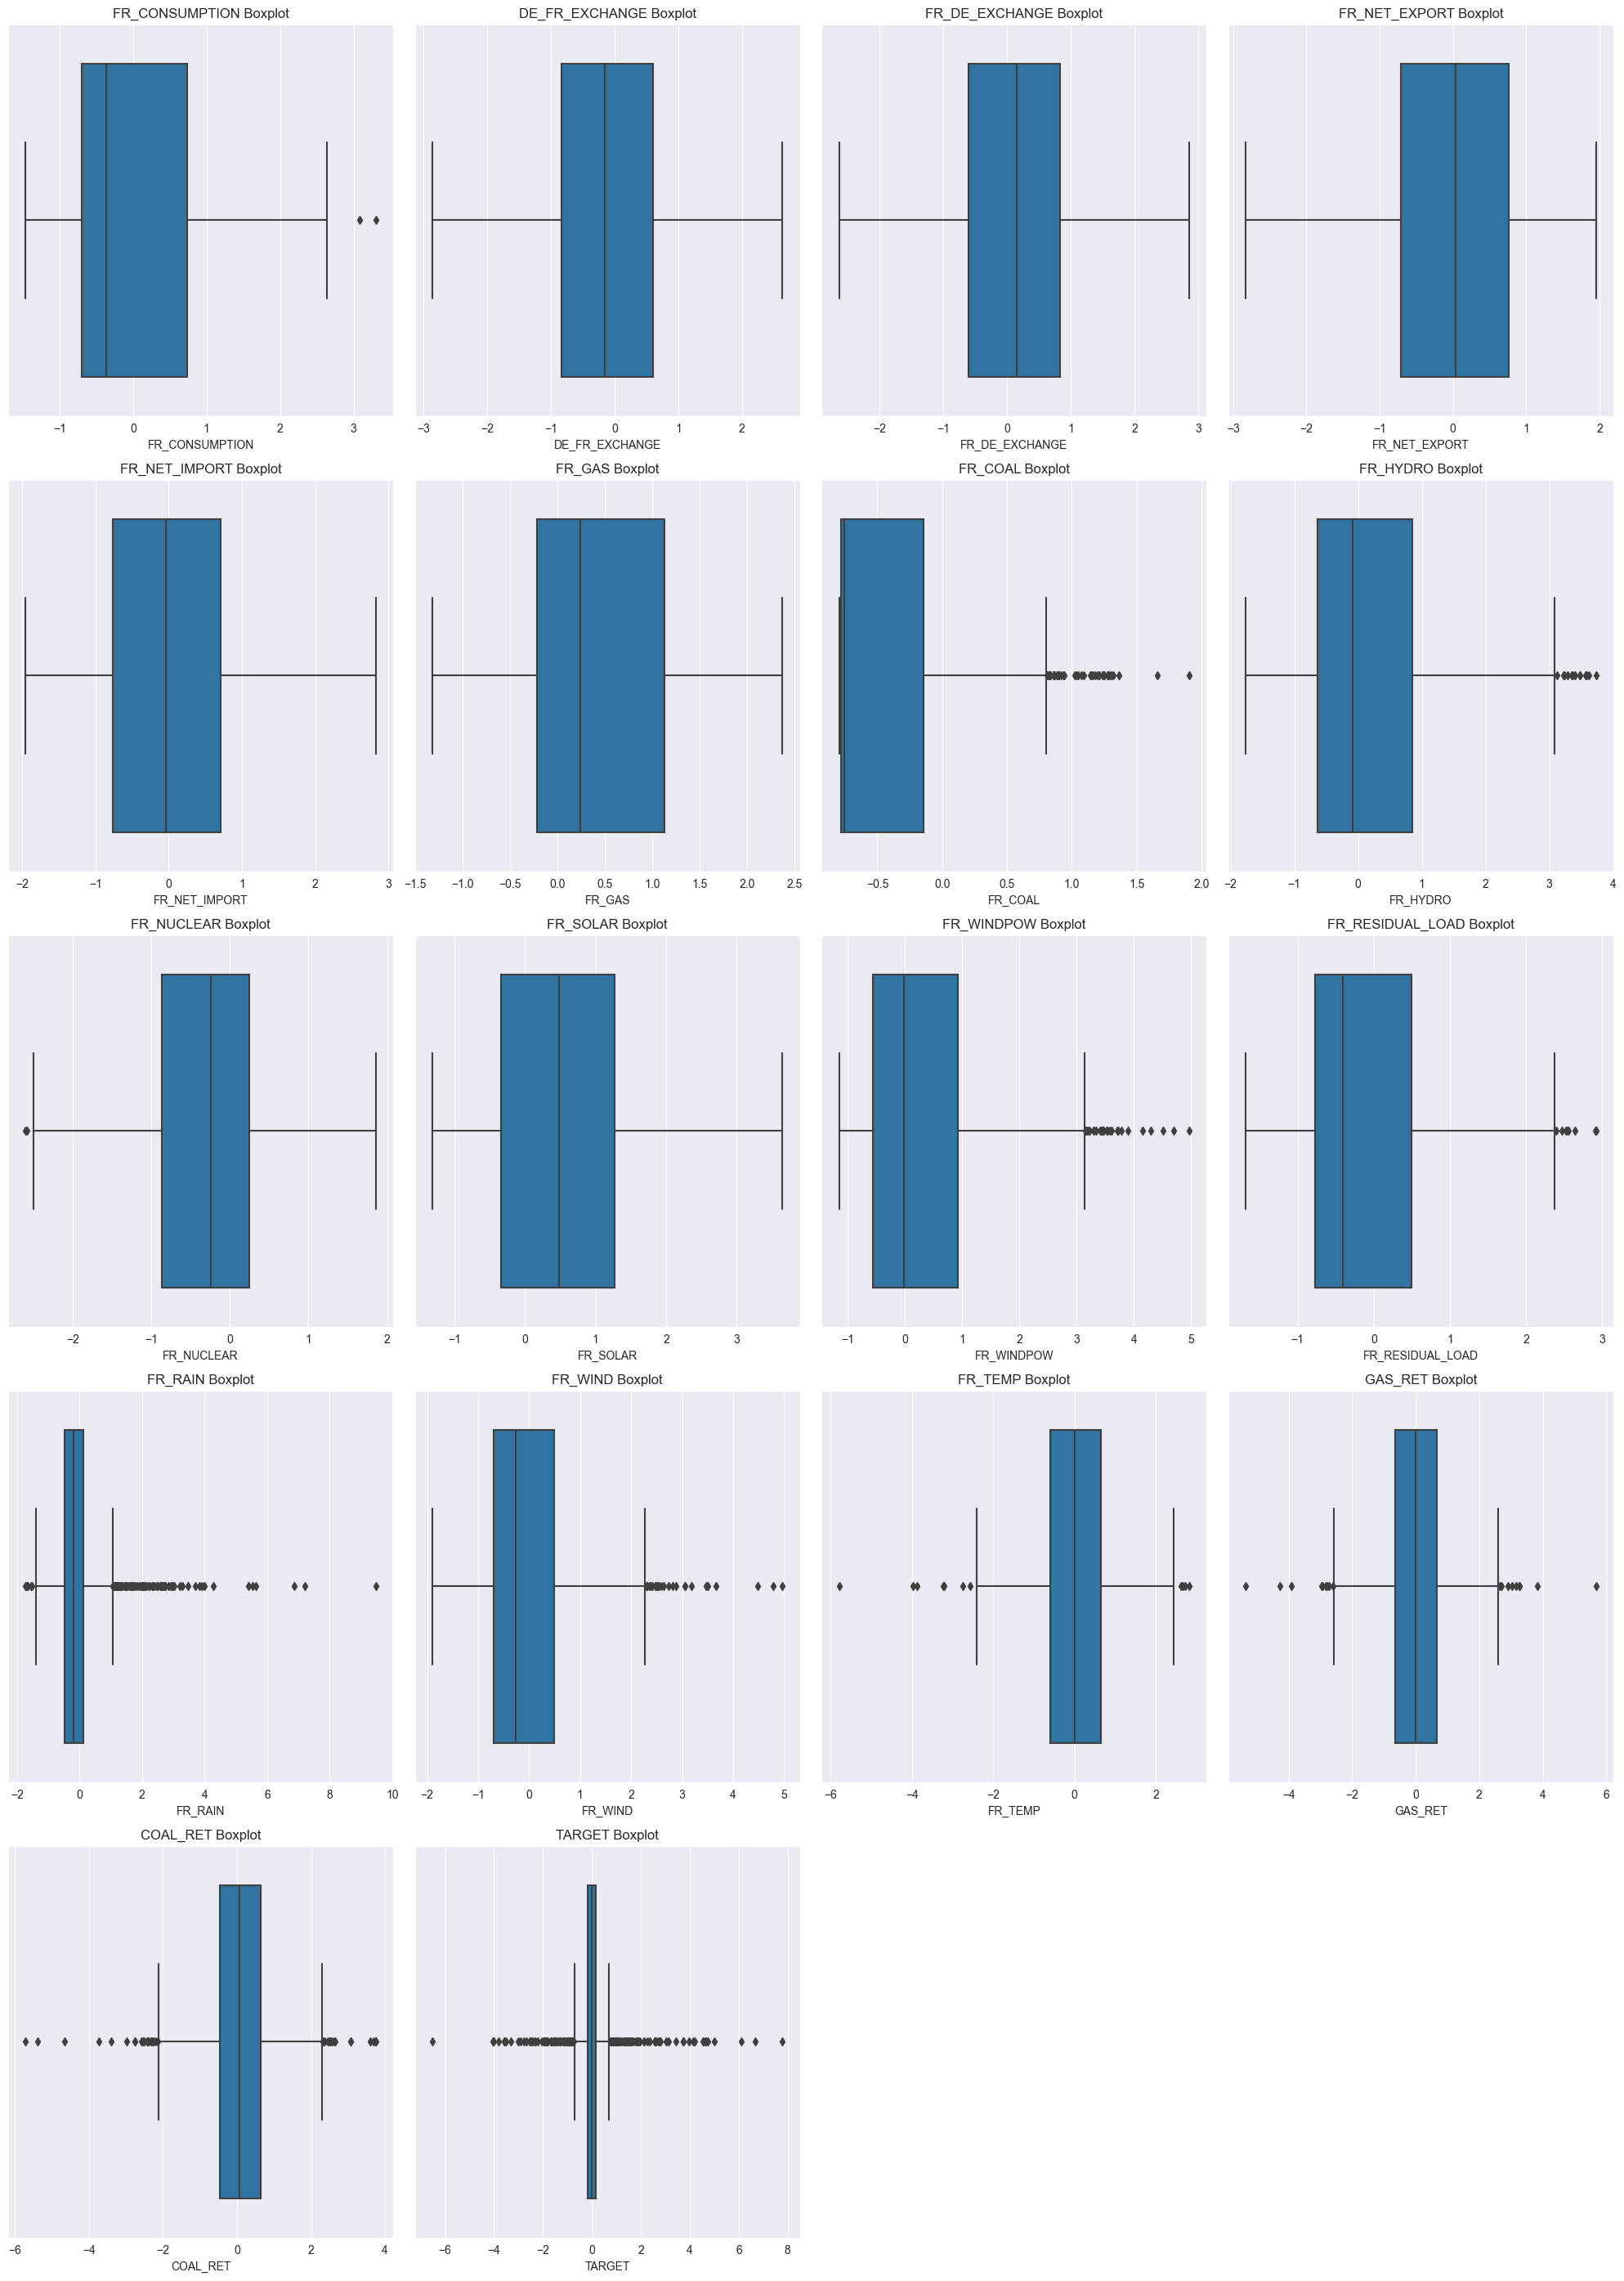

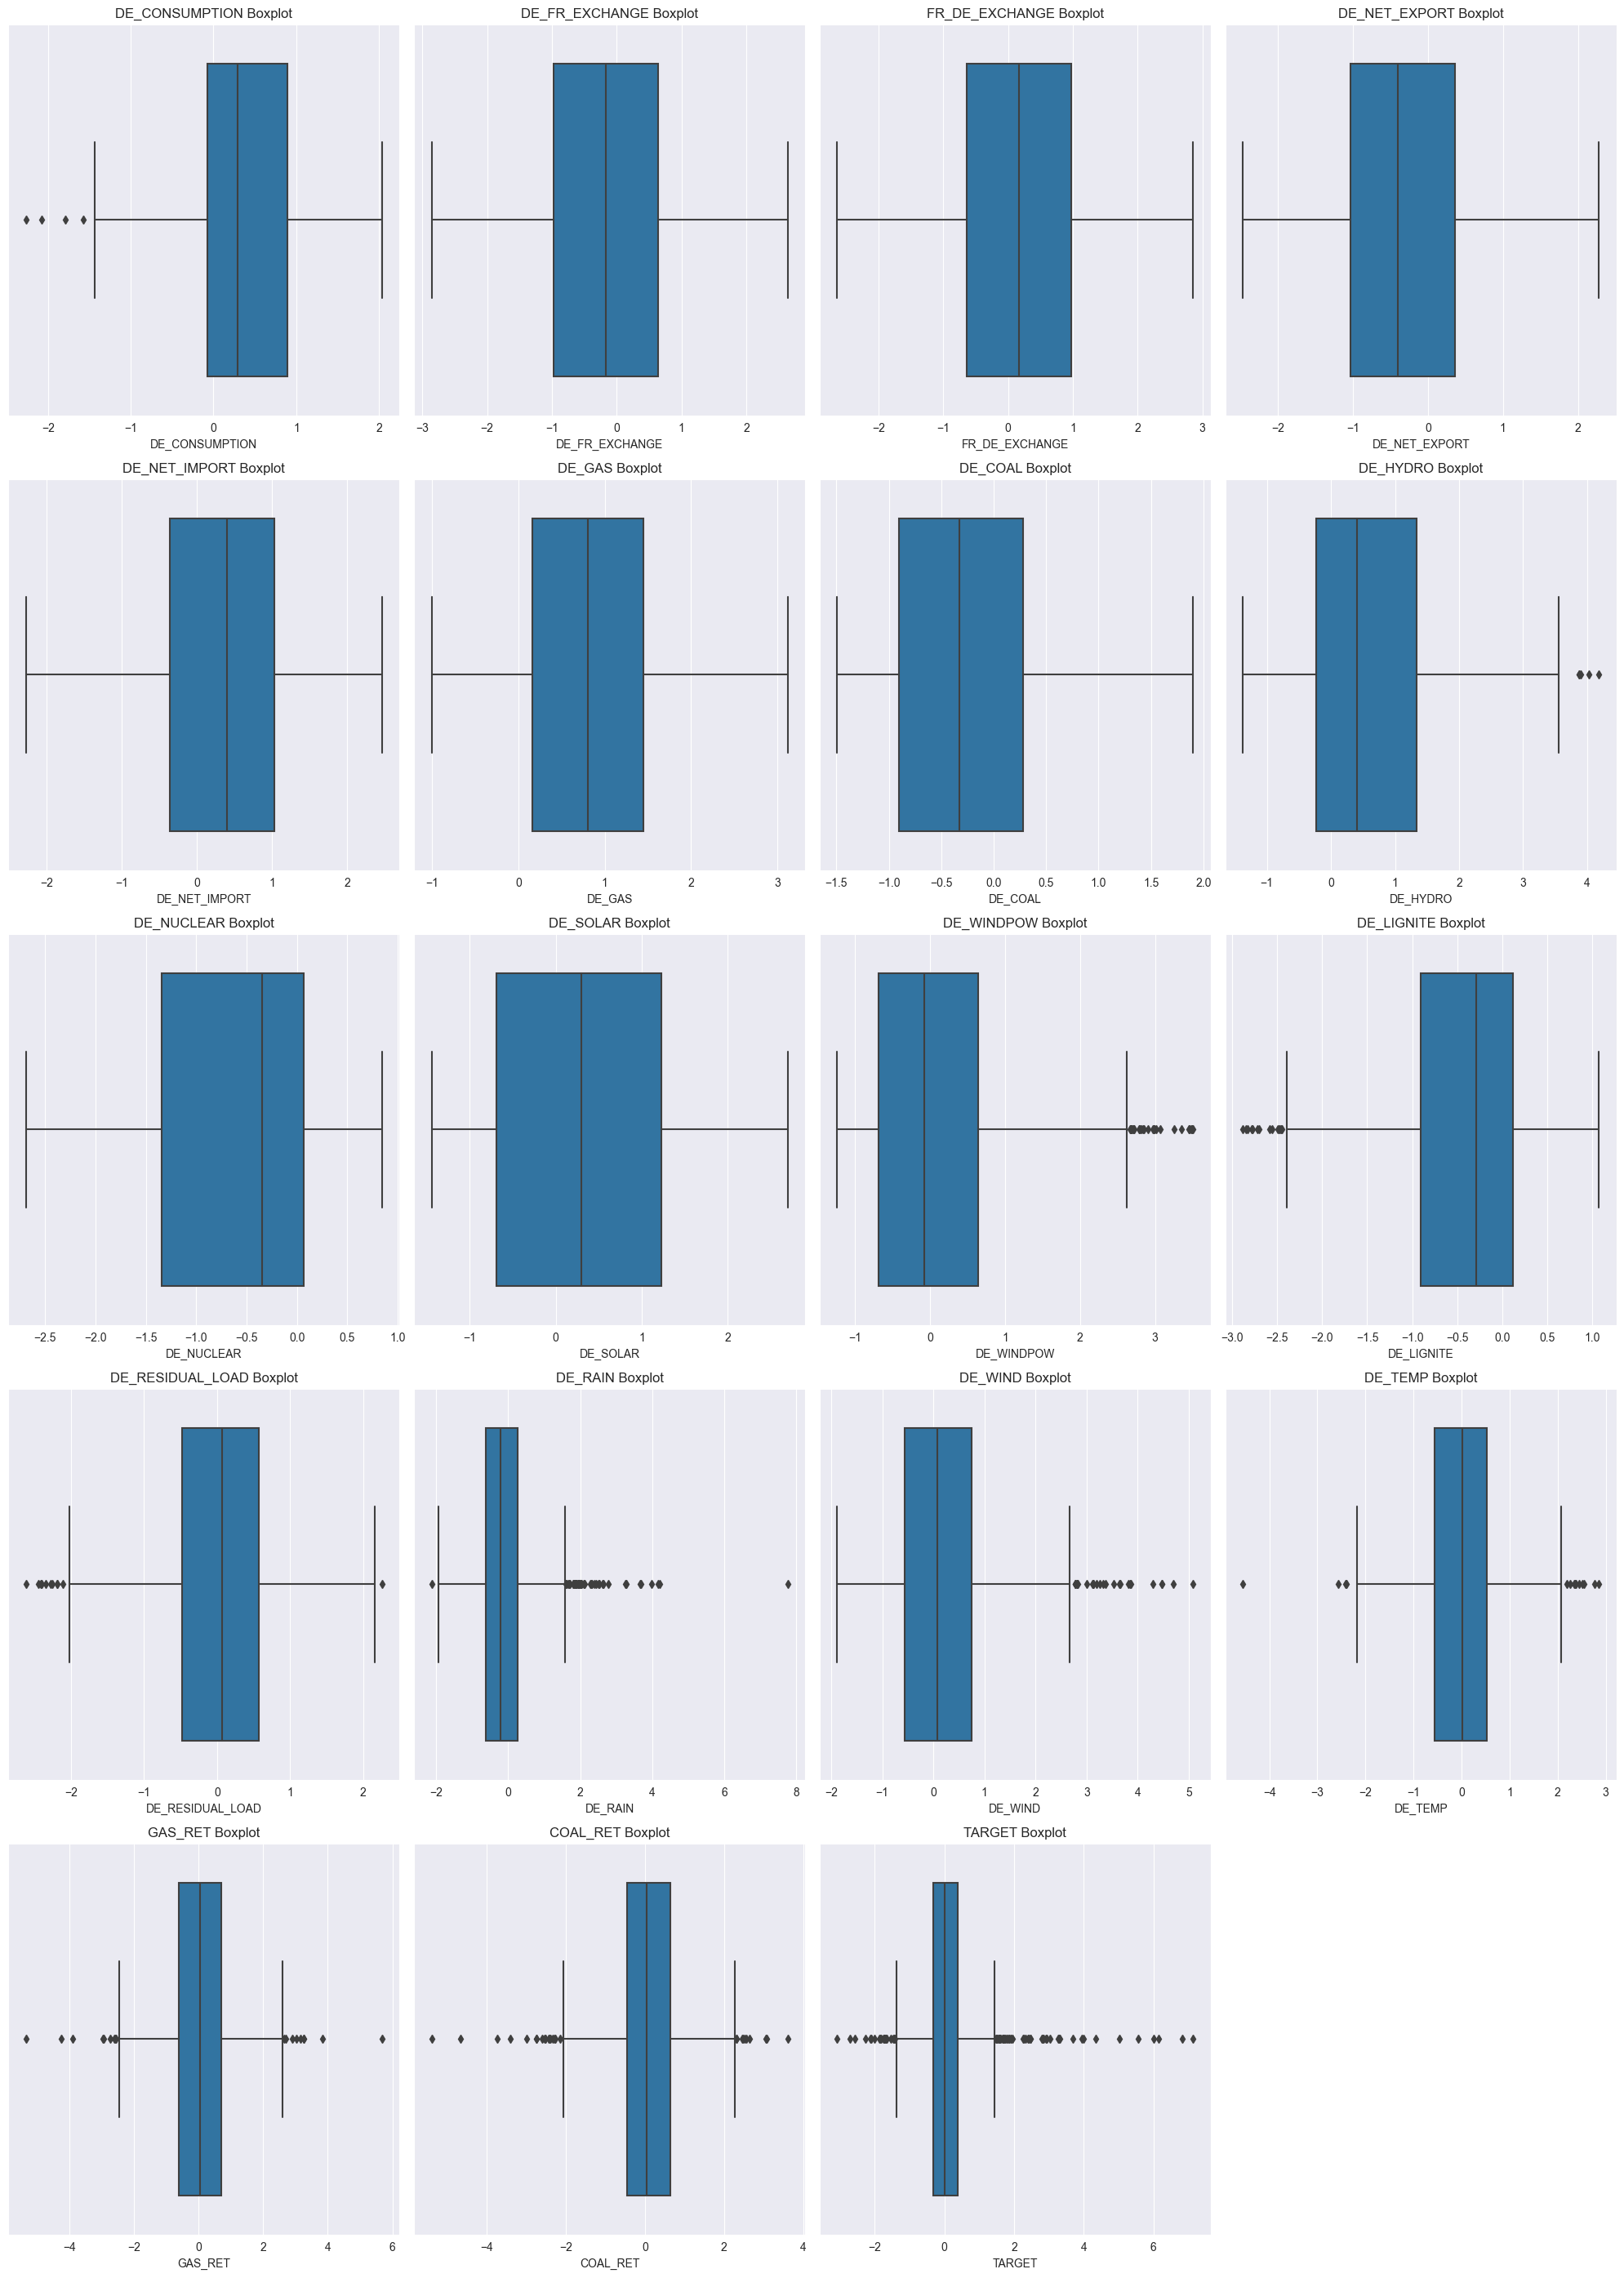

In [30]:
# création de diagrammes en boîtes
# pour la France
plt.figure(figsize=(20, 28))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, j in enumerate(data_FR.describe().columns):
    plt.subplot(5, 4, i+1)
    sns.boxplot(x=data_FR[j])
    plt.title('{} Boxplot'.format(j))

plt.tight_layout()
plt.show()

# pour l'Allemagne
plt.figure(figsize=(20, 28))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, j in enumerate(data_DE.describe().columns):
    plt.subplot(5, 4, i+1)
    sns.boxplot(x=data_DE[j])
    plt.title('{} Boxplot'.format(j))

plt.tight_layout()
plt.show()

On remarque que FR_CONSUMPTION, FR_COAL, FR_HYDRO, FR_WINDPOW, FR_RESIDUAL_LOAD, FR_RAIN, FR_WIND, FR_TEMP, GAS_RET, COAL_RET, TARGET possèdent de nombreuses valeurs aberrantes.

On remarque que DE_CONSUMPTION, DE_HYDRO, DE_WINDPOW, DE_LIGNITE, DE_RESIDUAL_LOAD, DE_RAIN, DE_WIND, DE_TEMP, GAS_RET, COAL_RET, TARGET possèdent de nombreuses valeurs aberrantes.

 et des graphiques de dispersion :

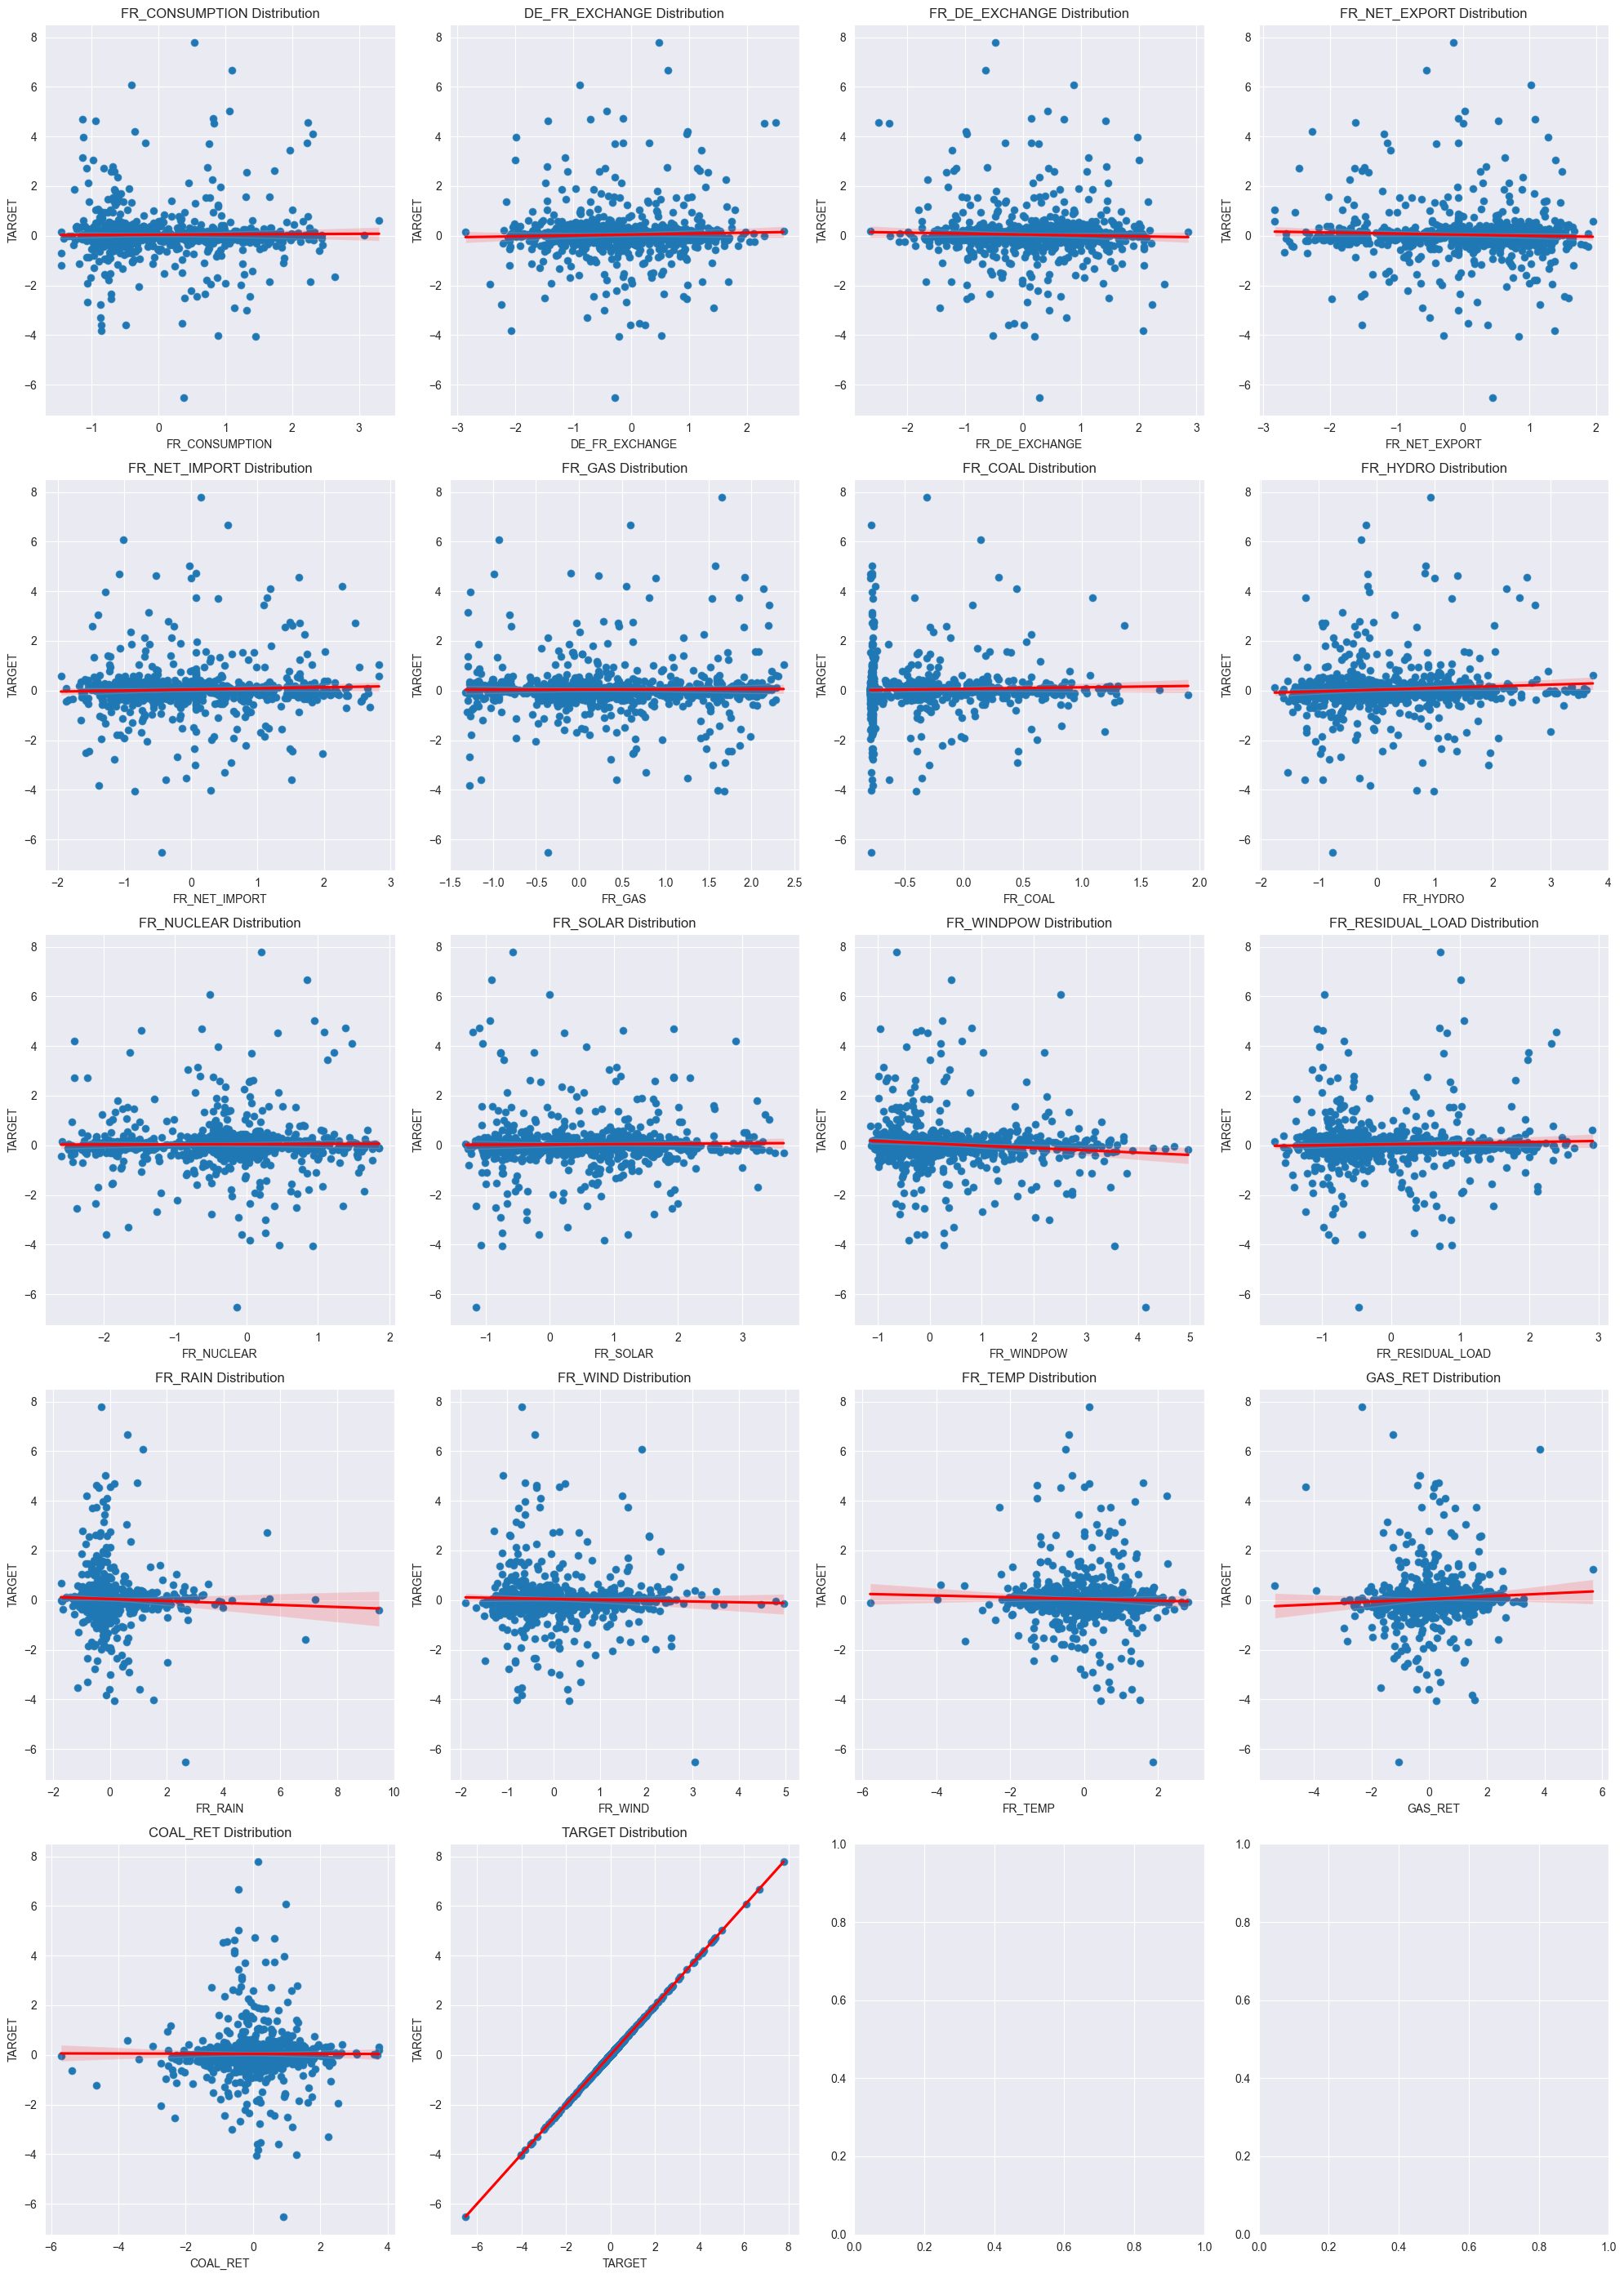

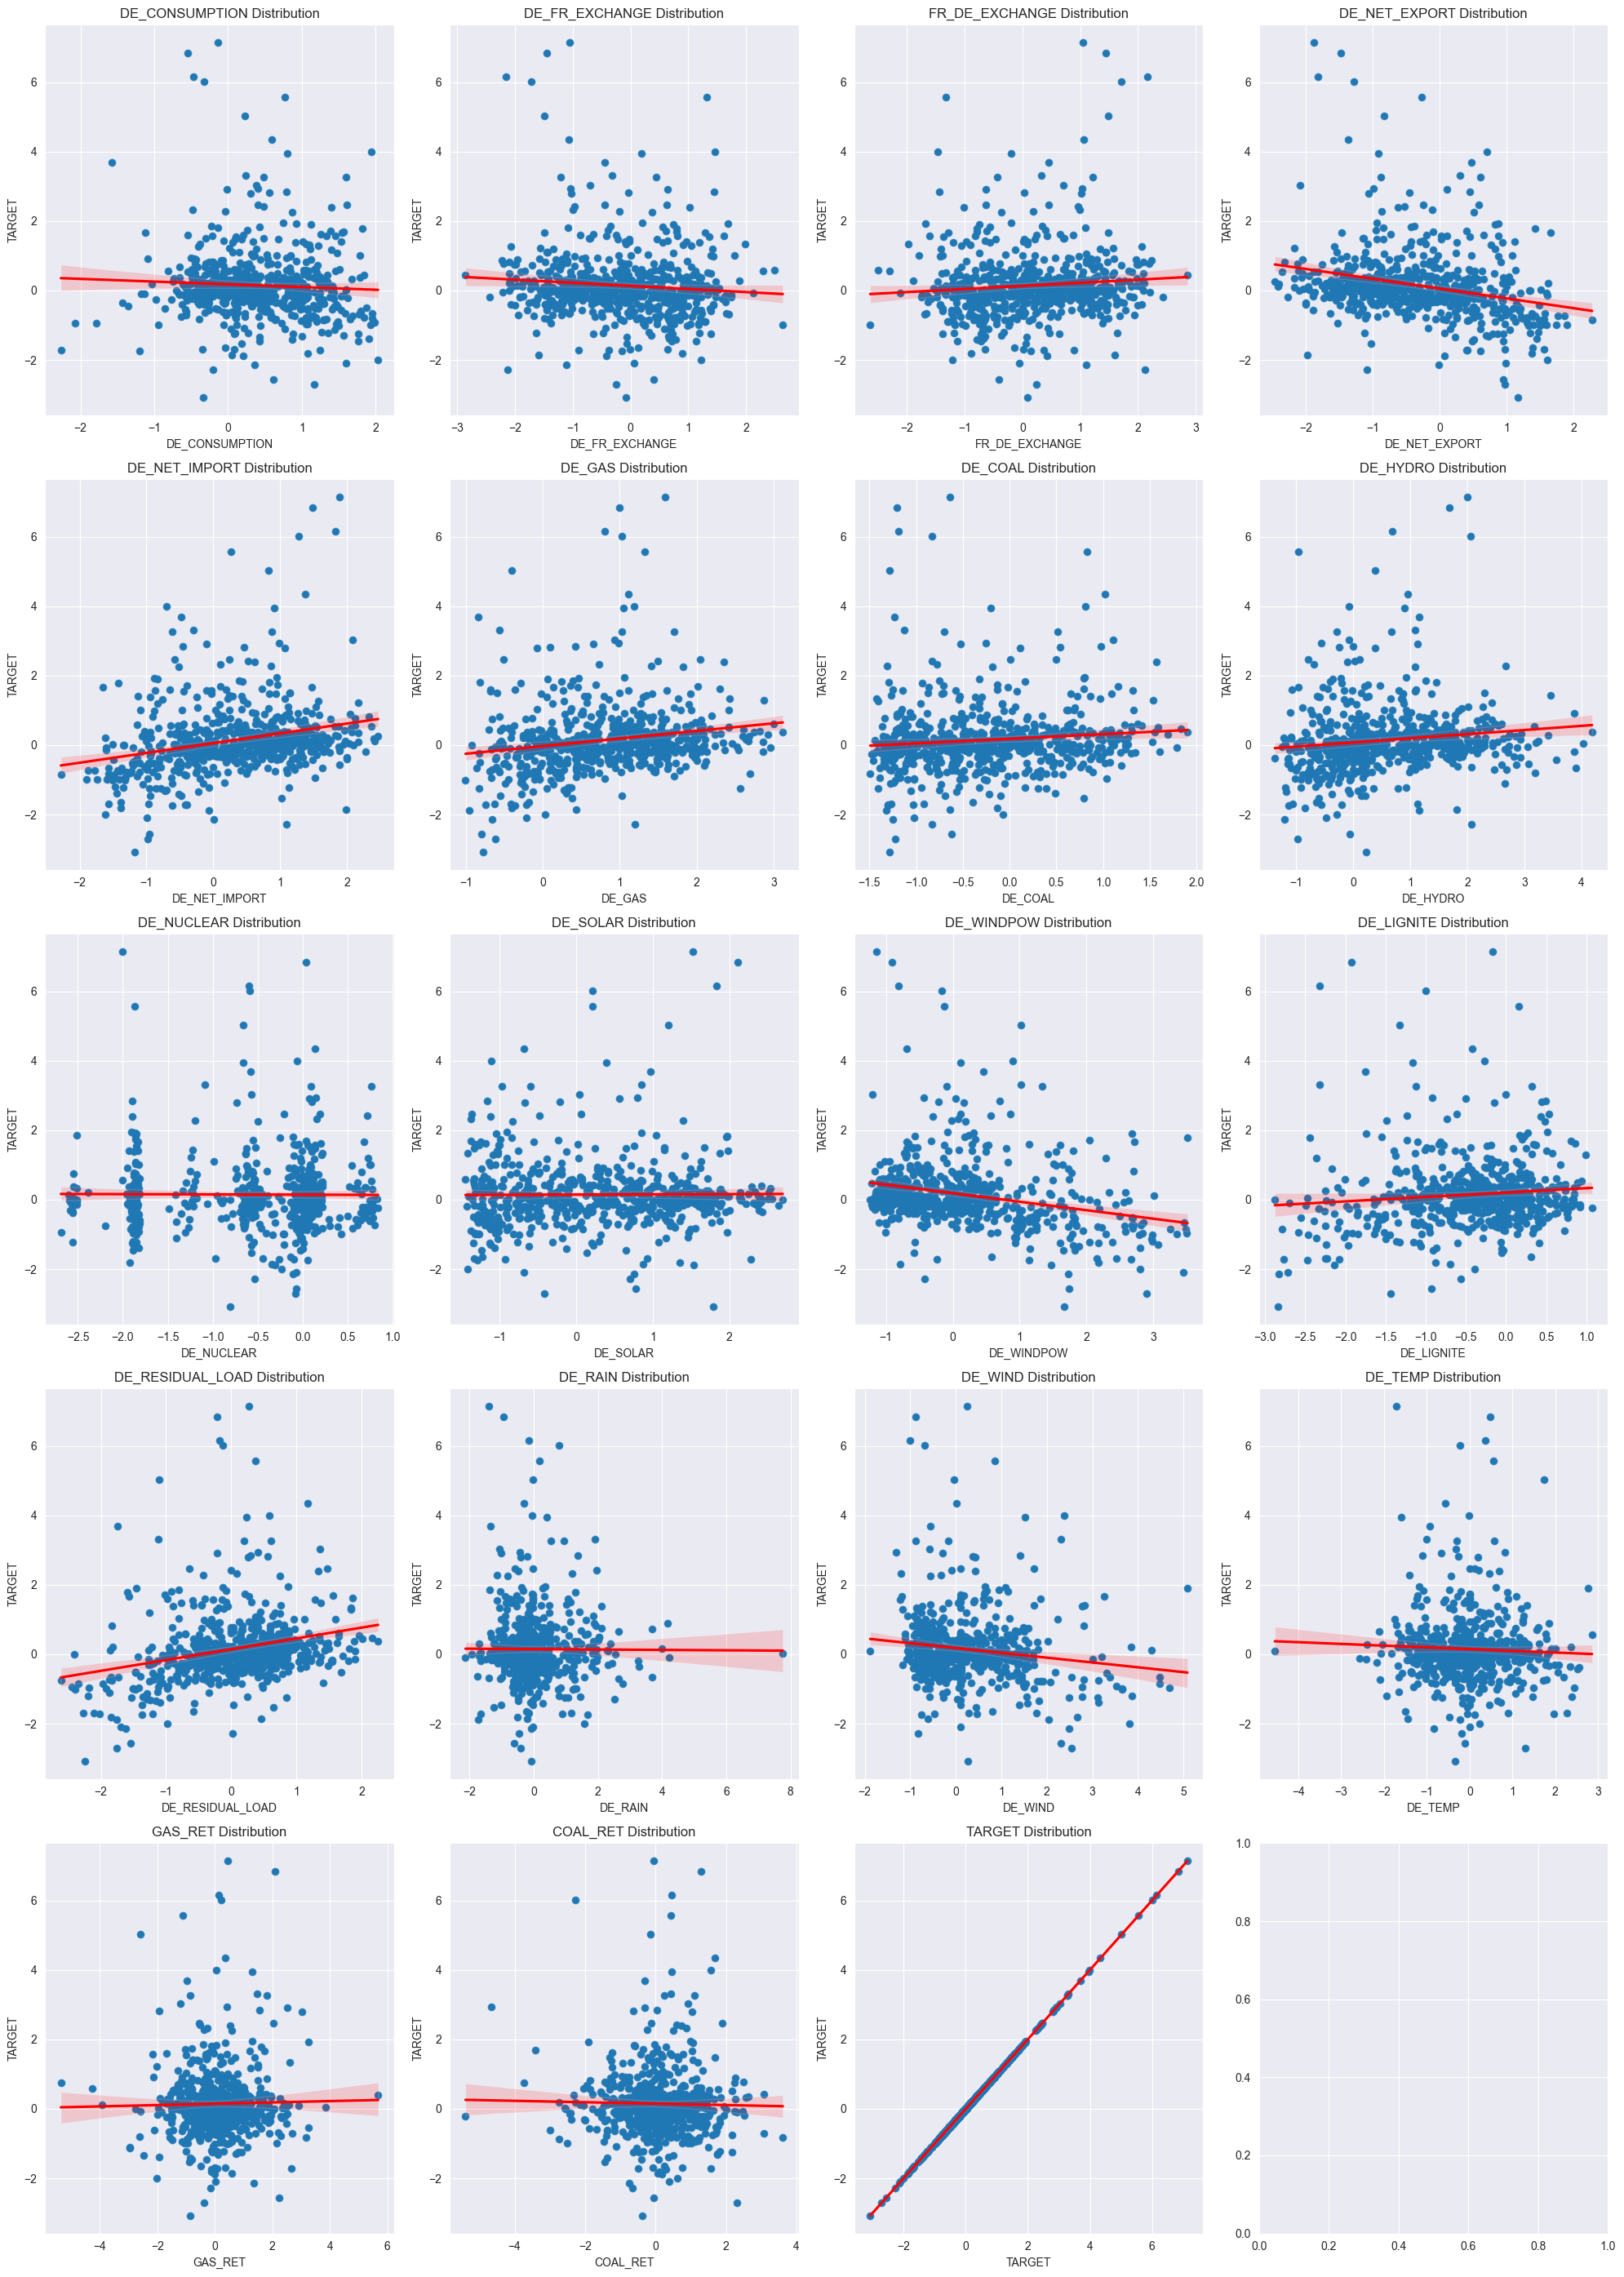

In [31]:
# création de diagrammes de dispersion
# pour la France
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 28))
for i, j in enumerate(data_FR.describe().columns):
    axes.flat[i].set_xlabel(j)
    sns.scatterplot(x=data_FR[j], y=data_FR.TARGET, ax=axes.flat[i])
    axes.flat[i].set_title(f'{j} Distribution')
    sns.regplot(x=data_FR[j], y=data_FR.TARGET, ax=axes.flat[i], line_kws={"color": "red"})

plt.tight_layout()
plt.show(block=True)

# pour l'Allemagne
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 28))
for i, j in enumerate(data_DE.describe().columns):
    axes.flat[i].set_xlabel(j)
    sns.scatterplot(x=data_DE[j], y=data_DE.TARGET, ax=axes.flat[i])
    axes.flat[i].set_title(f'{j} Distribution')
    sns.regplot(x=data_DE[j], y=data_DE.TARGET, ax=axes.flat[i], line_kws={"color": "red"})

plt.tight_layout()
plt.show(block=True)

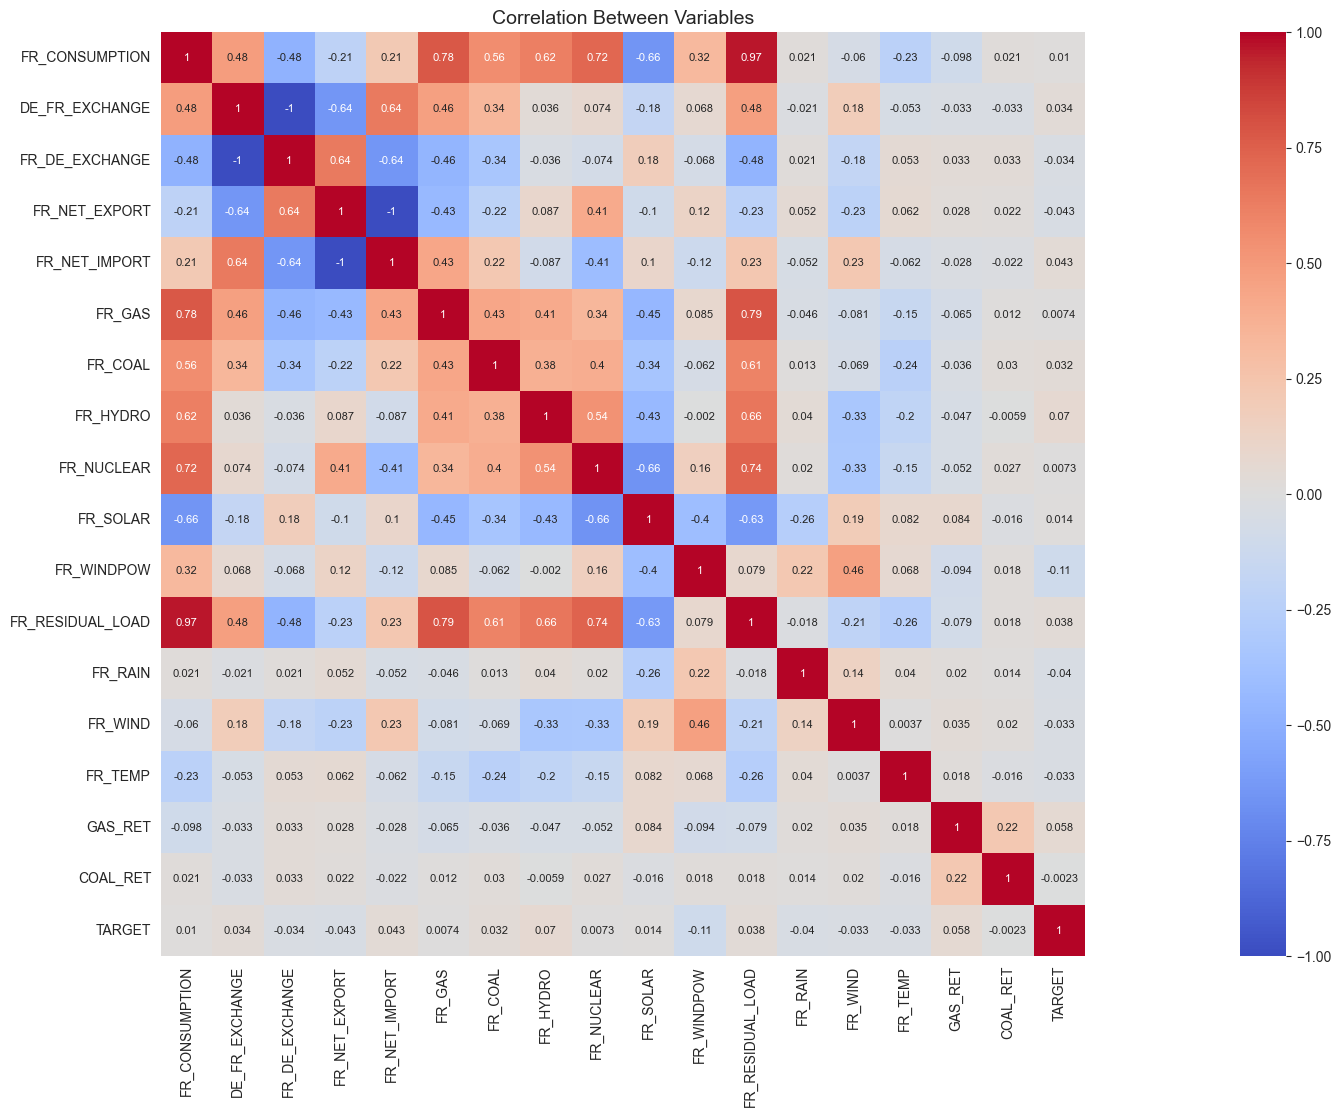

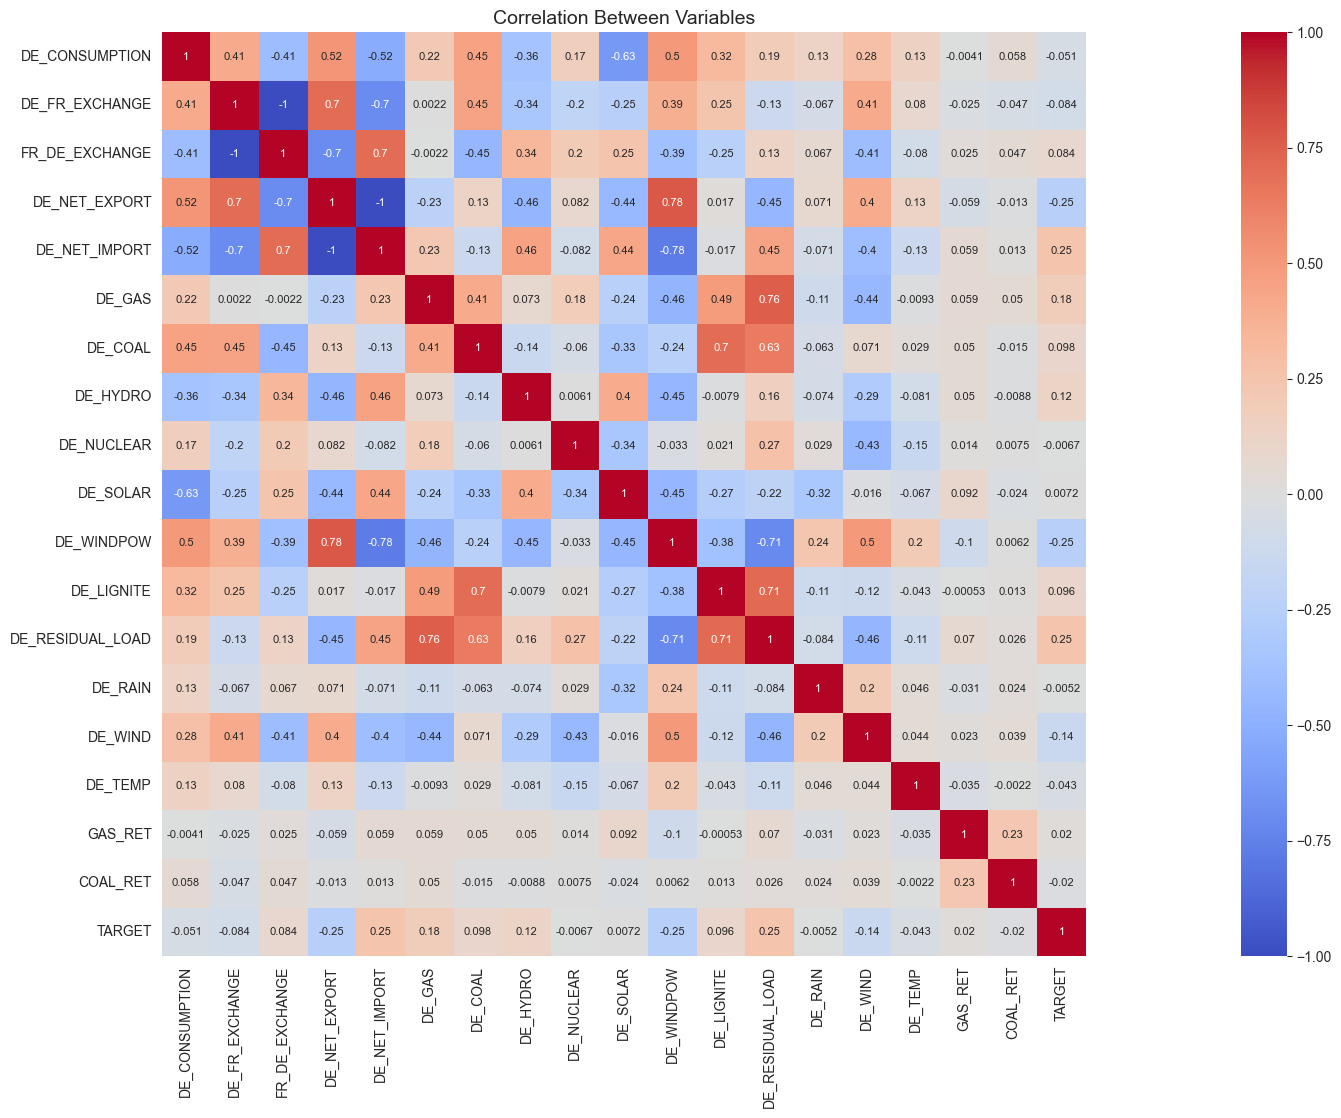

In [32]:
# Calculer la matrice de corrélation
# pour la France
correlation_metrics_1 = data_FR.corr()

# pour l'Allemagne
correlation_metrics_2 = data_DE.corr()

# Créer la heatmap avec une taille plus grande, une police plus petite et une palette de couleurs adaptée
# pour la France
fig1 = plt.figure(figsize=(40, 12))
sns.heatmap(correlation_metrics_1, square=True, annot=True, annot_kws={"size": 8}, vmax=1, vmin=-1, cmap='coolwarm')
plt.title('Correlation Between Variables', size=14)
plt.show()

# pour l'Allemagne
fig2 = plt.figure(figsize=(40, 12))
sns.heatmap(correlation_metrics_2, square=True, annot=True, annot_kws={"size": 8}, vmax=1, vmin=-1, cmap='coolwarm')
plt.title('Correlation Between Variables', size=14)
plt.show()

Pour la France, on aperçoit de très forte corrélation entre FR_NET_EXPORT et FR_DE_EXCHANGE (0.64), FR_NET_IMPORT et DE_FR_EXCHANGE (0.64), FR_GAS et FR_CONSUMPTION (0.78), FR_HYDRO et FR_CONSUMPTION (0.62), FR_NUCLEAR et FR_CONSUMPTION (0.72), FR_RESIDUAL_LOAD et FR_CONSUMPTION (0.97).


Pour l'Allemagne on s'aperçoit que les corrélations ne sont pas fortes mais il y a quelque variables qui possèdent des corrélations positives plus grandes de 0 entre les différentes variables et TARGET tels que : DE_NET_IMPORT (0.25), DE_GAS (0.18), DE_COAL (0.098), DE_HYDRO (0.12), DE_LIGNITE (0.096), DE_RESIDUAL_LOAD (0.25). Sinon, on aperçoit de très forte corrélation entre DE_NET_EXPORT et DE_FR_EXCHANGE (0.7), DE_NET_IMPORT et FR_DE_EXCHANGE (0.7), DE_WINDPOW et DE_NET_EXPORT (0.78), DE_LIGNITE et DE_COAL (0.7), DE_RESIDUAL_LOAD et DE_GAS (0.76).

Afin de préparer nos données pour effectuer KMEANS, nous avons changé nos datas en prenant les variables ayant le plus de valeurs aberrantes. Ensuite, nous avons enlevé ces valeurs afin d'avoir des datas plus propres.

      FR_COAL  FR_HYDRO  FR_WINDPOW  FR_RESIDUAL_LOAD   FR_RAIN   FR_WIND   
0   -0.766904  0.677089   -0.172140         -0.344706 -0.497520  0.488650  \
1   -0.718729  0.709616   -0.640389         -0.540642 -0.372156  0.021868   
2   -0.766063 -0.383690   -0.079343         -0.856321 -0.307449  0.123099   
3   -0.778036 -0.398178   -0.318923         -0.552878  0.019357  0.177514   
4   -0.755877 -0.739291   -0.009805         -0.806379 -0.528929 -0.273234   
..        ...       ...         ...               ...       ...       ...   
505 -0.771929  0.295769   -0.009106         -0.019808 -0.435577 -0.820883   
506 -0.774620 -0.191697   -0.389945          0.236243  0.019357 -0.667096   
507 -0.758579 -0.138441    0.839589         -0.666261 -0.202629  0.123099   
508 -0.776785 -0.380974   -0.468104         -0.589767 -0.237434 -0.463636   
509 -0.291751  0.780039   -0.266687         -0.223383  0.019357  0.123099   

      FR_TEMP   GAS_RET  COAL_RET    TARGET  
0    0.583874  0.440121 -0.07

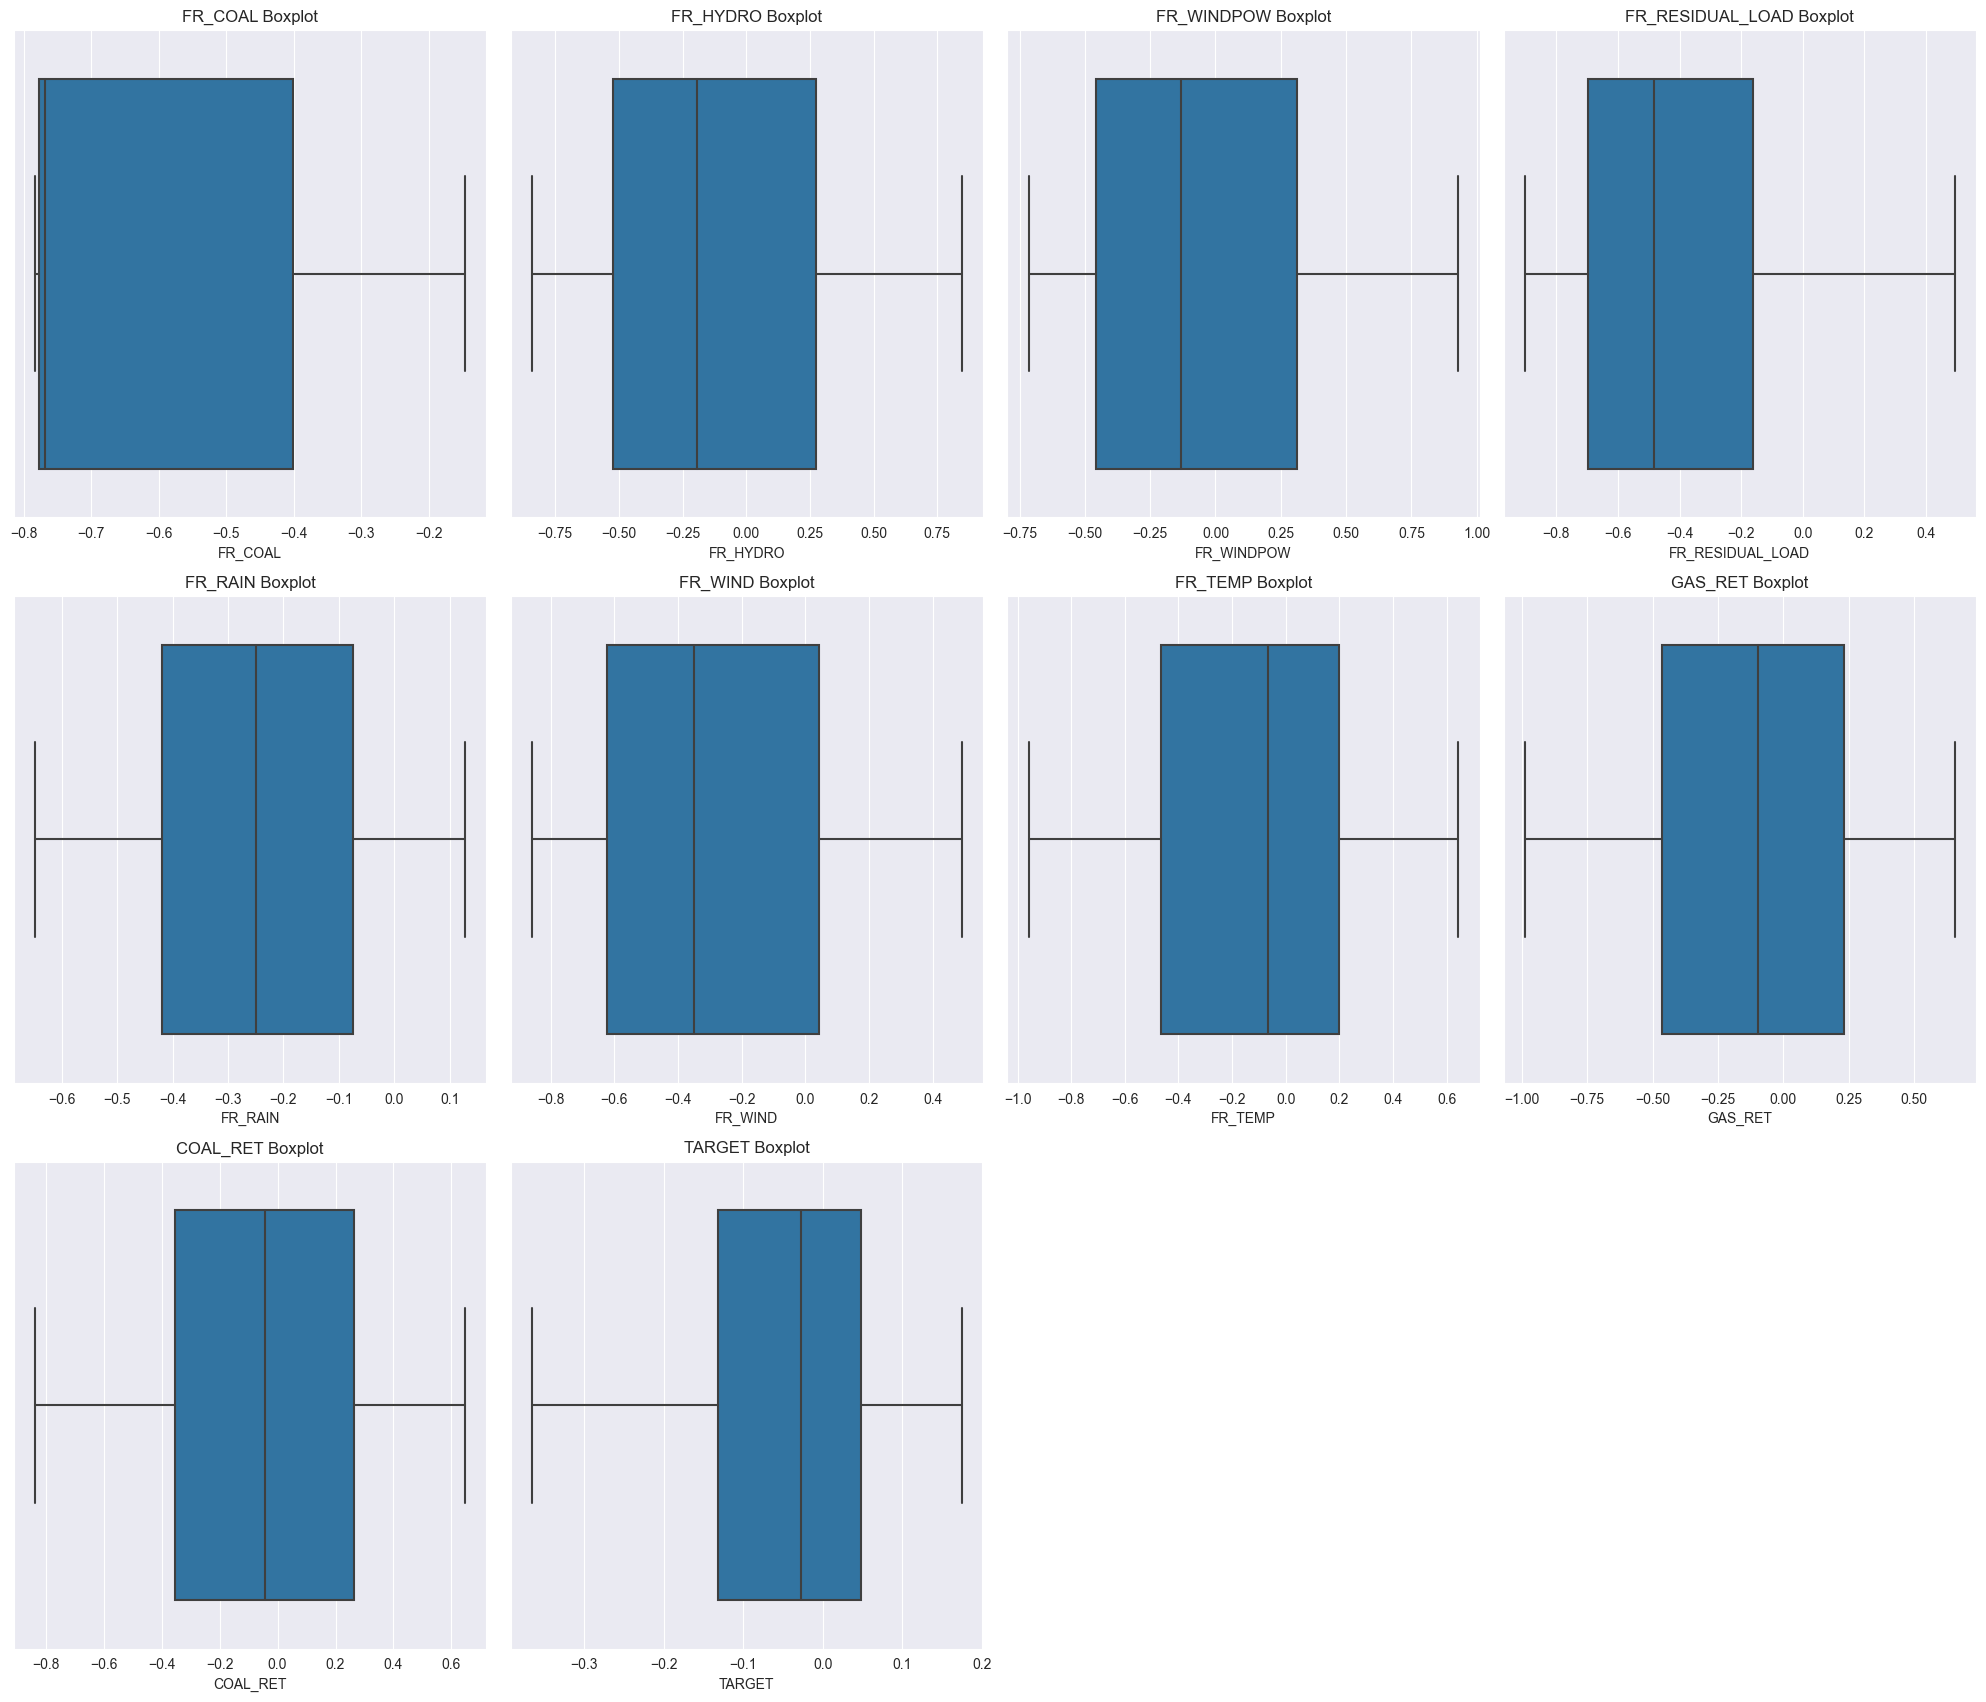

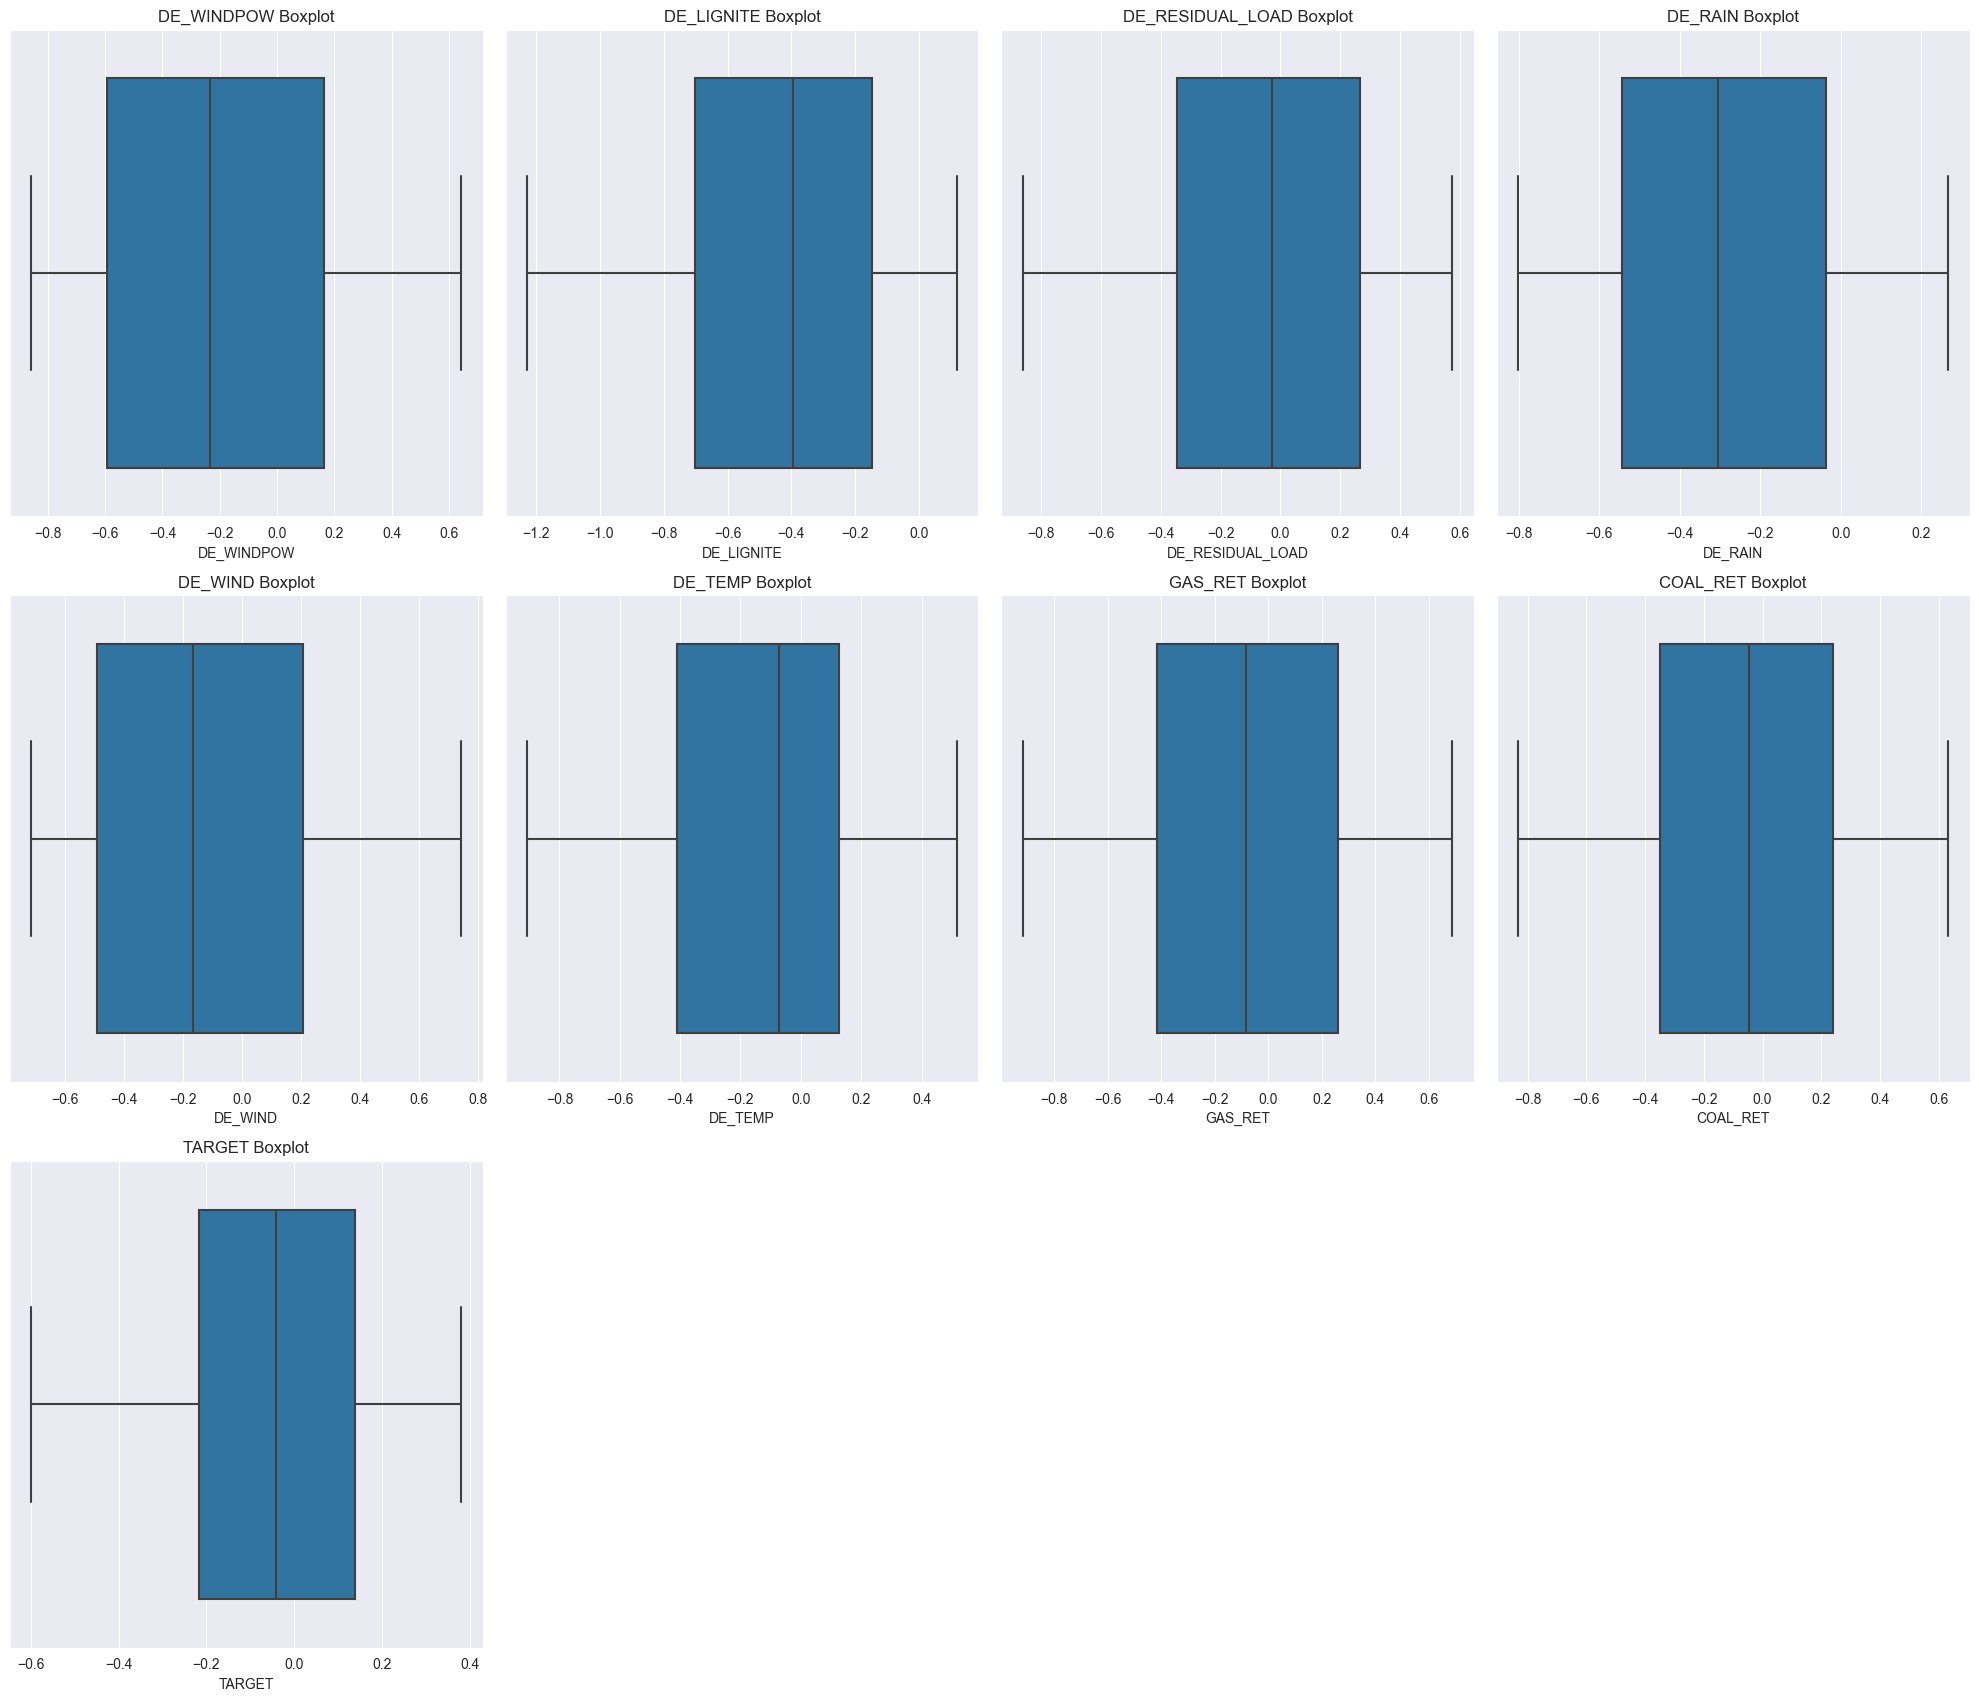

In [72]:
import numpy as np

# sélectionne les variables qui nous intéressent
data_FR = data_FR.filter(regex='FR_COAL|FR_HYDRO|FR_WINDPOW|FR_RESIDUAL_LOAD|FR_RAIN|FR_WIND|FR_TEMP|GAS_RET|COAL_RET|TARGET', axis=1)
data_DE = data_DE.filter(regex='DE_WINDPOW|DE_LIGNITE|DE_RESIDUAL_LOAD|DE_RAIN|DE_WIND|DE_TEMP|GAS_RET|COAL_RET|TARGET', axis=1)

# suppression des valeurs aberrantes
# pour la France

# Définir les pourcentages de valeurs à supprimer
lower_percentile = 15
upper_percentile = 75

# Appliquer le trimming à chaque variable
trimmed_data = {}

for i, j in enumerate(data_FR.describe().columns):
    variable = data_FR[j]
    trimmed_variable = variable[(variable >= np.percentile(variable, lower_percentile)) & (variable <= np.percentile(variable, upper_percentile))]
    trimmed_data[j] = trimmed_variable.to_numpy()

data_FR_trimmed = pd.DataFrame(trimmed_data)
# Vérifier le résultat
print(data_FR_trimmed)

# pour l'Allemagne
lower_percentile = 15
upper_percentile = 75

trimmed_data_2= {}

for i, j in enumerate(data_DE.describe().columns):
    variable = data_DE[j]
    trimmed_variable = variable[(variable >= np.percentile(variable, lower_percentile)) & (variable <= np.percentile(variable, upper_percentile))]
    trimmed_data_2[j] = trimmed_variable.to_numpy()

data_DE_trimmed = pd.DataFrame(trimmed_data_2)

print(data_DE_trimmed)

# affichage des diagrammes en boîte pour la France
plt.figure(figsize=(20, 28))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, j in enumerate(data_FR_trimmed.describe().columns):
    plt.subplot(5, 4, i+1)
    sns.boxplot(x=data_FR_trimmed[j])
    plt.title('{} Boxplot'.format(j))

plt.tight_layout()
plt.show()

# pour l'Allemagne
plt.figure(figsize=(20, 28))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, j in enumerate(data_DE_trimmed.describe().columns):
    plt.subplot(5, 4, i+1)
    sns.boxplot(x=data_DE_trimmed[j])
    plt.title('{} Boxplot'.format(j))

plt.tight_layout()
plt.show()

C) Modélisation des données

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = data_FR_trimmed['COAL_RET'].values
Y = data_FR_trimmed['TARGET'].values

X = X.reshape(-1,1)
Y = Y.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, Y)

lin = LinearRegression()
lin.fit(X_train, y_train)
print(lin.coef_)

r2_score(y_test, lin.predict(X_test))

[[-0.00710018]]


0.0005813099467738558